# <h1><center>Feature Extraction For Unsupervised Clustering Models

In [1]:
# Set random state for notebook
random_state = 42

In [2]:
# Enable multiple cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Import appropriate packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import statistics
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from plotnine import *
import plotnine
import string
import re
import pickle
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import gensim
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from yellowbrick.cluster import SilhouetteVisualizer
from gensim.models import Doc2Vec
from wordcloud import WordCloud
from autocorrect import Speller
import collections, itertools
from collections import Counter

# download and define stopwords for text pre-processing
nltk.download('stopwords')
stop = stopwords.words('english')

C:\Users\geaco\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Table of Contents
* [1. Introduction and Importing Data](#one)
* [2. Categorical and Numeric Features](#two)
    * [a. Data Cleaning](#twoa)
    * [b. Data Visualization](#twob)
    * [c. Feature Extraction](#twoc)
    * [d. Run K-Prototypes Clustering Model](#twod)
    * [e. Clustering Analysis](#twoe)
* [3. Free Text Features](#three)
    * [a. Data Cleaning](#threea)
    * [b. Feature Extraction](#threeb)
    * [c. Run Clustering Models](#threec)
        * [i. TF-IDF](#threeci)
        * [ii. Doc2Vec](#threecii)
        * [iii. Distill Roberta](#threeciii)
        * [iv. MP-Net](#threeciv)
    * [d. Data Visualization](#threed)
    * [e. Clustering Analysis For Best Permoring Model](#threee)

# Introduction and Importing Data <a class="anchor" id="one"></a>

This notebook employs various clustering models to perform customer segmentation tasks using unsupervised learning. The data consists of categorical, numeric, and free text features, so appropriate models were selected to best fit the different feature types. The data is sourced from Centrepoint, a non-profit focusing on youth homelessness. Both datasets consist of data collected from phone calls and webchats Centrepoint representatives field from young people experiencing or at-risk of homelessness and their advocates. The helpline dataset represents conversations with the young people themselves and the enquiry dataset represents conversations with people calling on behalf of a young person.  

In [4]:
# Import Data
# Assign Excel files to appropriate DataFrames

# Helpline Data
helpline = pd.read_excel('C:/Users/geaco/OneDrive/Documents/Dissertation/Data/Helpline Data.xlsx')

# Enquiry Data
enquiry = pd.read_excel('C:/Users/geaco/OneDrive/Documents/Dissertation/Data/Enquiry Data.xlsx')

# Categorical and Numeric Features <a class="anchor" id="two"></a>

This section consists of the data cleaning, feature extraction, and model running and evaluation for the categorical and numeric features of the helpline dataset. The K-Prototypes model was the only clustering model I was able to find that could handle both types of features, so it is the only model I employ in this section.

## Data Cleaning <a class="anchor" id="twoa"></a>

This section involves initial data cleaning for the categorical and numeric features. In this section, I only use the helpline data set because the enquiry data had too high a share null values in many of the categorical features for any relevant insights to be gained. 

In [5]:
# Overview of helpline data
helpline.info()
helpline.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Housing Situation                         15555 non-null  object        
 1   Timeline Event Notes                      1123 non-null   object        
 2   Timeline End Date                         10025 non-null  datetime64[ns]
 3   Referral date                             14104 non-null  datetime64[ns]
 4   Timeline Start Date                       16309 non-null  datetime64[ns]
 5   Approached Social Services                934 non-null    object        
 6   Approached Housing                        993 non-null    object        
 7   In EET                                    16309 non-null  object        
 8   Recurring Case of Homelessness            5986 non-null   object        
 9   YP heard/has a voice        

Housing Situation Timeline Event Notes Timeline End Date  \
0                Rough sleeping                  NaN        2019-11-11   
1            Living with family                  NaN               NaT   
2            Living with family                  NaN               NaT   
3  Did Not Disclose / Not Known                  NaN               NaT   
4  Did Not Disclose / Not Known                  NaN               NaT   

  Referral date Timeline Start Date Approached Social Services  \
0    2019-11-11          2019-11-11                        NaN   
1    2020-08-14          2020-08-14                        NaN   
2    2020-09-07          2020-09-07                        NaN   
3    2020-10-16          2020-10-16                        NaN   
4    2021-03-03          2021-03-03                        NaN   

  Approached Housing                      In EET  \
0                NaN  Unknown / Did Not Disclose   
1                NaN  Unknown / Did Not Disclose   
2                NaN  Unknown / Did Not Disclose   
3                NaN  Unknown / Did Not Disclose   
4                NaN  Unknown / Did Not Disclose   

  Recurring Case of Homelessness YP heard/has a voice  ...  \
0                            NaN                  NaN  ...   
1                     Don't Know                  NaN  ...   
2                     Don't Know                  NaN  ...   
3                     Don't Know                  NaN  ...   
4                     Don't Know                  NaN  ...   

  YP directly referred to another service Time in current housing situation  \
0                                     NaN                           Unknown   
1                                     NaN                           Unknown   
2                                     NaN                               0-3   
3                                     NaN                           Unknown   
4                                     NaN                               0-3   

  Outcome from Approaching Housing Outcome from Approaching Social Services  \
0                              NaN                                      NaN   
1                              NaN                                      NaN   
2                              NaN                                      NaN   
3                              NaN                                      NaN   
4                              NaN                                      NaN   

    Age             Ethnic Origin         Immigration Status  \
0  26.0  Did not wish to disclose                  Not Known   
1  21.0                 Not Known  Does not wish to disclose   
2  27.0                 Not Known  Does not wish to disclose   
3  20.0  Did not wish to disclose            British Citizen   
4  20.0                 Not Known  Does not wish to disclose   

  Are you a care leaver? How Long in Care?      Has children?  
0                    NaN               NaN          Not Known  
1                    NaN               NaN  Prefer not to say  
2                    NaN               NaN  Prefer not to say  
3                    NaN               NaN          Not Known  
4                    NaN               NaN  Prefer not to say  

[5 rows x 52 columns]

In [6]:
# Check for null values in helpline data
helpline_pct_null = helpline.isnull().sum() * 100 / len(helpline)
helpline_pct_null

Housing Situation                            4.623214
Timeline Event Notes                        93.114231
Timeline End Date                           38.530873
Referral date                               13.520142
Timeline Start Date                          0.000000
Approached Social Services                  94.273101
Approached Housing                          93.911337
In EET                                       0.000000
Recurring Case of Homelessness              63.296339
YP heard/has a voice                        99.987737
YP better understood their rights           99.981605
Mental Health Needs                         94.806549
Gender                                       0.000000
Additional causes of homelessness 'Other    99.613710
Additional causes of homelessness           97.504445
Current Borough YP Is In                     8.719112
Region                                       8.719112
Local connections                           52.284015
Main cause of homelessness '

In [7]:
# Create a data frame that drops columns with more than 80% null values to discard unusuable columns
perc = 80.0
min_count =  int(((100-perc)/100)*helpline.shape[0] + 1)
mod_helpline = helpline.dropna( axis=1, 
                thresh=min_count)

In [8]:
# Check each of the remaining for unknown or inappropriate labels so they can be fixed prior to prepping data for models
mod_helpline['Housing Situation'].value_counts()

Sofa-surfing                            4790
Living with family                      2824
Rough sleeping                          2272
Did Not Disclose / Not Known            2051
Other                                   1260
Living with friends                      573
Private sector tenancy                   468
Any other temp accom                     361
Living with partner                      176
Bed and breakfast                        140
Supported housing                        129
Direct access hostel                     112
Local authority general need tenancy      62
Student accommodation                     42
HA general needs tenancy                  40
Hospital                                  39
Women's refuge                            34
Staying on Buses                          22
Guardianship property                     22
Home Office Asylum Support                19
Short life housing                        19
Tied housing or rented with job           17
Children's

In [9]:
mod_helpline['In EET'].value_counts()

Unknown / Did Not Disclose      14580
Job Seeker                        969
Full-time work > 24 hrs / wk      255
Full-time Student                 169
Part-time work < 24 hrs /wk       128
Not Working or Claiming            89
Long-term Sick / Disabled          58
Part-time Student                  19
Not Eligible to Work               19
Apprenticeship                     17
Child under 16                      6
Name: In EET, dtype: int64

In [10]:
mod_helpline['Recurring Case of Homelessness'].value_counts()

Don't Know    5523
Yes            346
No             117
Name: Recurring Case of Homelessness, dtype: int64

In [11]:
mod_helpline['Gender'].value_counts()

Female       8314
Male         7140
Refused       753
Other          67
Not Known      35
Name: Gender, dtype: int64

In [12]:
mod_helpline['Main cause of homelessness'].value_counts()

Family breakdown                                                4809
Not Known                                                       3010
Did not disclose                                                2151
Unknown                                                         1018
Eviction                                                        1017
Relationship breakdown                                           817
Other (please specify)                                           669
Domestic abuse                                                   605
Released from an institution with no accommodation to return     241
Harassment, threat of violence                                   219
Surrendered property                                             177
LA care come to an end                                            65
Death of a family member/carer                                    59
Student with no family to return to out of term                   52
No recourse to public funds       

In [13]:
mod_helpline['Main cause of homelessness sub-category'].value_counts()

Family Breakdown - Arguments with parent (s)                                 1660
Domestic Abuse - YP Victim                                                    411
Eviction - Rent arrears                                                       212
Family Breakdown - Over crowding                                              165
Family Breakdown - Arguments with siblings/wider family                       152
Released From Institution - Prison                                            127
Eviction - Anti Social Behaviour                                              101
Family Breakdown - Sexuality of YP                                             71
Eviction - Unlawful Eviction                                                   70
Family Breakdown - Parents mental health                                       62
Harassment, threat of violence - General from outside the home                 59
Family Breakdown - Parents substance misuse                                    59
Family Breakdown

In [14]:
mod_helpline['Housing situation details'].value_counts()

Did not disclose                                                                                                                                                                                                                                                                         204
not disclosed                                                                                                                                                                                                                                                                            149
Unknown                                                                                                                                                                                                                                                                                   54
not known                                                                                                                                        

In [15]:
mod_helpline['At risk of Homelessness due to'].value_counts()

Family breakdown                                                2190
Did not disclose                                                 896
Eviction                                                         659
Unknown                                                          529
Other (please specify)                                           385
Domestic abuse                                                   317
Relationship breakdown                                           183
Harassment, threat of violence                                   110
Surrendered property                                              96
Released from an institution with no accommodation to return      53
Student with no family to return to out of term                   45
LA care come to an end                                            31
Death of a family member/carer                                    17
No recourse to public funds                                       11
Forced Marriage                   

In [16]:
mod_helpline['Care Status'].value_counts()

Not Known             15454
Never been in care      630
Left Care               202
Currently in Care        23
Name: Care Status, dtype: int64

In [17]:
mod_helpline['Benefits'].value_counts()

Not Known                                                                 14095
Not working or claiming                                                    1042
Universal credit                                                            958
JSA - income based                                                           65
PIP                                                                          28
ESA - support group                                                          24
Universal credit;PIP                                                         23
ESA - work related activity group                                            19
ESA - work related activity group;PIP                                        11
Income support                                                                8
Universal credit;Housing benefit                                              7
Housing benefit                                                               6
Child tax credit                        

In [18]:
mod_helpline['Priority need'].value_counts()

Not Known    12949
Yes           2292
No            1062
Name: Priority need, dtype: int64

In [19]:
mod_helpline['Is SWEP open in this council area?'].value_counts()

No                                 6828
Unknown                             550
Yes                                  78
Unable to find out from council       7
Name: Is SWEP open in this council area?, dtype: int64

In [20]:
mod_helpline['Time in current housing situation'].value_counts()

Unknown                14155
0-3                     1642
12+                      252
2021-06-03 00:00:00      160
2021-09-06 00:00:00      100
Name: Time in current housing situation, dtype: int64

In [21]:
mod_helpline['Ethnic Origin'].value_counts()

Did not wish to disclose              9553
Not Known                             5681
White: British                         533
Black/Black British: African           134
Mixed: White & Black Caribbean          92
Black/Black British: Caribbean          84
Asian/Asian British: Pakistani          38
Arab                                    34
Black/Black British: Other              26
White: Other                            25
Gypsy/Irish Traveller                   21
Mixed: Other                            18
Asian/Asian British: Other              16
Mixed: White & Black African            14
Chinese/Other ethnic group: Other        9
Asian/Asian British: Indian              9
Mixed: White & Asian                     9
White: Irish                             7
Asian/Asian British: Bangladeshi         5
Chinese/Other ethnic group:Chinese       1
Name: Ethnic Origin, dtype: int64

In [22]:
mod_helpline['Immigration Status'].value_counts()

Not Known                                                 8470
Does not wish to disclose                                 4874
British Citizen                                           2359
Citizen of other EEA country                               265
Indefinite leave to remain/enter                            93
Refugee status                                              62
Client does not know                                        40
Asylum seeker                                               33
Did not ask                                                 25
Refugee                                                     24
Discretionary leave (DL)                                    17
Destitute Migrant                                           15
Other – specify in notes                                     9
Naturalised as a British citizen                             6
Limited Leave - other                                        4
Humanitarian Protection                                

In [23]:
mod_helpline['Region'].value_counts()

London                  5144
North West England      4300
South East England      1044
Yorkshire and Humber     829
West Midlands            799
East of England          702
South West England       526
NOT KNOWN                521
North East England       439
East Midlands            409
East Midlands            163
None                       5
Scotland                   3
Wales                      2
Northern Ireland           1
Name: Region, dtype: int64

In [24]:
mod_helpline['Has children?'].value_counts()

Not Known                            9165
Prefer not to say                    4419
No                                   1544
Yes                                   735
Yes - Pregnant / Pregnant Partner     380
No - Child Removed                     64
Yes - Adoption                          2
Name: Has children?, dtype: int64

In [25]:
pd.set_option('display.max_rows', 450)
borough = pd.DataFrame(mod_helpline['Current Borough YP Is In'].value_counts()).reset_index()
borough.sort_values(by='Current Borough YP Is In', ascending=False)

index  Current Borough YP Is In
0                                Manchester                      2976
1                                 NOT KNOWN                       521
2                                   Lambeth                       395
3                                 Southwark                       295
4                                   Croydon                       283
5                                Birmingham                       272
6                                     Brent                       272
7                                  Lewisham                       264
8                                   Hackney                       237
9                                    Newham                       230
10                            Tower Hamlets                       198
11                                 Bradford                       195
12                                Greenwich                       193
13                                 Haringey                       183
14                               Wandsworth                       180
15                                   Camden                       179
16                   Hammersmith and Fulham                       175
17                                  Enfield                       174
18                                Islington                       169
19                              Westminster                       168
20                           Waltham Forest                       167
21                      Kent County Council                       164
22                                  Salford                       158
23                                   Ealing                       158
24                                    Leeds                       156
25                               Nottingham                       152
26                     Barking and Dagenham                       136
27                                   Barnet                       133
28                                  Bromley                       117
29                     Essex County Council                       111
30                                 Tameside                       111
31                                Liverpool                       109
33                                Leicester                       108
32                                Redbridge                       108
34                                   Oldham                       107
35                                 Barnsley                       107
36                                 Hounslow                       106
37                               Sunderland                       103
38                                 Trafford                       102
39                               Hillingdon                       100
40                                  Bristol                        94
41                                    Derby                        91
42                                Stockport                        87
43                                 Havering                        86
44                      Newcastle upon Tyne                        85
45             Hertfordshire County Council                        85
46                                   Bexley                        84
47                              Northampton                        82
48                                   Bolton                        77
49                                   Harrow                        77
50                  Cheshire County Council                        76
51                                 Rochdale                        73
52                                 Coventry                        72
53                                Sheffield                        71
54                Lancashire County Council                        70
55                    Surrey County Council                        66
56                   Kensington and Chelsea     

In [26]:
pd.set_option('display.max_rows', 150)
local = pd.DataFrame(mod_helpline['Local connections'].value_counts())
local.sort_values(by='Local connections', ascending = False)

Local connections
Manchester                                   1665
NOT KNOWN                                    1134
Lambeth                                       149
Croydon                                       121
Lewisham                                      118
...                                           ...
Richmondshire                                   1
Blackburn;Manchester                            1
Barking & Dagenham;Newham                       1
Darlington;Newcastle-upon-Tyne                  1
Tamworth                                        1

[459 rows x 1 columns]

In [27]:
# Replace unkown lables with null values
mod_helpline['Housing Situation'] = mod_helpline['Housing Situation'].replace('NOT KNOWN', np.nan)
mod_helpline['Housing Situation'] = mod_helpline['Housing Situation'].replace('Did Not Disclose / Not Known', np.nan)
mod_helpline['In EET'] = mod_helpline['In EET'].replace('Unknown / Did Not Disclose', np.nan)
mod_helpline['Recurring Case of Homelessness'] = mod_helpline['Recurring Case of Homelessness'].replace('Unknown / Did Not Disclose', np.nan)
mod_helpline['Gender'] = mod_helpline['Gender'].replace('Refused', np.nan)
mod_helpline['Gender'] = mod_helpline['Gender'].replace('Not Known', np.nan)
mod_helpline['Main cause of homelessness'] = mod_helpline['Main cause of homelessness'].replace('Not Known', np.nan)
mod_helpline['Main cause of homelessness'] = mod_helpline['Main cause of homelessness'].replace('Did not disclose', np.nan)
mod_helpline['Main cause of homelessness'] = mod_helpline['Main cause of homelessness'].replace('Unknown', np.nan)
mod_helpline['Housing situation details'] = mod_helpline['Housing situation details'].replace('Did not disclose', np.nan)
mod_helpline['Housing situation details'] = mod_helpline['Housing situation details'].replace('not disclosed', np.nan)
mod_helpline['Housing situation details'] = mod_helpline['Housing situation details'].replace('not known', np.nan)
mod_helpline['Housing situation details'] = mod_helpline['Housing situation details'].replace('Unknown', np.nan)
mod_helpline['Housing situation details'] = mod_helpline['Housing situation details'].replace('Did not disclose.', np.nan)
mod_helpline['At risk of Homelessness due to'] = mod_helpline['At risk of Homelessness due to'].replace('Did not disclose', np.nan)
mod_helpline['At risk of Homelessness due to'] = mod_helpline['At risk of Homelessness due to'].replace('Unknown', np.nan)
mod_helpline['Care Status'] = mod_helpline['Care Status'].replace('Not Known', np.nan)
mod_helpline['Benefits'] = mod_helpline['Benefits'].replace('Not Known', np.nan)
mod_helpline['Priority need'] = mod_helpline['Priority need'].replace('Not Known', np.nan)
mod_helpline['Is SWEP open in this council area?'] = mod_helpline['Is SWEP open in this council area?'].replace('Unknown', np.nan)
mod_helpline['Is SWEP open in this council area?'] = mod_helpline['Is SWEP open in this council area?'].replace('Unable to find out from council', np.nan)
mod_helpline['Time in current housing situation'] = mod_helpline['Time in current housing situation'].replace('Unknown', np.nan)
mod_helpline['Ethnic Origin'] = mod_helpline['Ethnic Origin'].replace('Not Known', np.nan)
mod_helpline['Ethnic Origin'] = mod_helpline['Ethnic Origin'].replace('Did not wish to disclose', np.nan)
mod_helpline['Immigration Status'] = mod_helpline['Immigration Status'].replace('Does not wish to disclose ', np.nan)
mod_helpline['Immigration Status'] = mod_helpline['Immigration Status'].replace('Not Known', np.nan)
mod_helpline['Has children?'] = mod_helpline['Has children?'].replace('Not Known', np.nan)
mod_helpline['Has children?'] = mod_helpline['Has children?'].replace('Prefer not to say', np.nan)
mod_helpline['Current Borough YP Is In'] = mod_helpline['Current Borough YP Is In'].replace('NOT KNOWN', np.nan)
mod_helpline['Local connections'] = mod_helpline['Local connections'].replace('NOT KNOWN', np.nan)

<ipython-input-27-1541b9d72667>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-27-1541b9d72667>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-27-1541b9d72667>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-27-1541b9d72667>

In [28]:
# Drop redundant columns
mod_helpline = mod_helpline.drop(columns=['Type of Timeline','Referral date','Timeline End Date','Local connections','Timeline Status']).reset_index()

In [29]:
# Drop columns with more than 80% null values
perc = 80.0
min_count =  int(((100-perc)/100)*mod_helpline.shape[0] + 1)
mod_helpline = mod_helpline.dropna( axis=1, 
                thresh=min_count)

## Create Simple Additional Features

In [30]:
# Create year and month columns
mod_helpline['year'] = pd.DatetimeIndex(mod_helpline['Timeline Start Date']).year
mod_helpline['month'] = pd.DatetimeIndex(mod_helpline['Timeline Start Date']).month

In [31]:
# Create is_currently_homeless feature based on whether indivudal is at risk of or experiencing homelessness
mod_helpline["Status"] = np.where(mod_helpline['At risk of Homelessness due to'].isnull(), 'Experiencing Homelessness', 'At-risk')

In [32]:
# Rename index column to 'id'
mod_helpline.rename(columns={'index':'id'}, inplace=True)

In [33]:
# Overview of cleaned data frame
mod_helpline.head()
mod_helpline.info()

id   Housing Situation Timeline Start Date Recurring Case of Homelessness  \
0   0      Rough sleeping          2019-11-11                            NaN   
1   1  Living with family          2020-08-14                     Don't Know   
2   2  Living with family          2020-09-07                     Don't Know   
3   3                 NaN          2020-10-16                     Don't Know   
4   4                 NaN          2021-03-03                     Don't Know   

  Gender Current Borough YP Is In    Region Main cause of homelessness  \
0   Male            Aberdeen City  Scotland                        NaN   
1   Male                   Abroad      None                        NaN   
2   Male                   Abroad      None     Other (please specify)   
3   Male                   Abroad      None                        NaN   
4   Male                   Abroad      None                        NaN   

                           Housing situation details  \
0                                                NaN   
1  YP has been staying with relatives in Europe f...   
2       He had no job and went to Malaysia to settle   
3                                                NaN   
4                                                NaN   

  At risk of Homelessness due to Main cause of homelessness sub-category  \
0                            NaN                                     NaN   
1               Family breakdown                                     NaN   
2         Other (please specify)                                     NaN   
3                            NaN                                     NaN   
4         Other (please specify)                                     NaN   

  Priority need Is SWEP open in this council area?   Age  \
0           NaN                                NaN  26.0   
1           NaN                                 No  21.0   
2           NaN                                 No  27.0   
3           NaN                                 No  20.0   
4           NaN                                 No  20.0   

          Immigration Status  year  month                     Status  
0                        NaN  2019     11  Experiencing Homelessness  
1  Does not wish to disclose  2020      8                    At-risk  
2  Does not wish to disclose  2020      9                    At-risk  
3            British Citizen  2020     10  Experiencing Homelessness  
4  Does not wish to disclose  2021      3                    At-risk

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       16309 non-null  int64         
 1   Housing Situation                        13504 non-null  object        
 2   Timeline Start Date                      16309 non-null  datetime64[ns]
 3   Recurring Case of Homelessness           5986 non-null   object        
 4   Gender                                   15521 non-null  object        
 5   Current Borough YP Is In                 14366 non-null  object        
 6   Region                                   14887 non-null  object        
 7   Main cause of homelessness               8814 non-null   object        
 8   Housing situation details                6123 non-null   object        
 9   At risk of Homelessness due to         

## Data Visualization <a class="anchor" id="twob"></a>

This section uses visualizations to provide a brief descriptive analysis of the categorical and numeric features. As noted in the previous section, data quality issues involving null values made many of the features in the helpline data set unusable. In general, the data skews younger and more female, while the region, main cause of homelessness, and housing situation features show that these features are highly skewed, with one or two categories dominating the respective columns. 

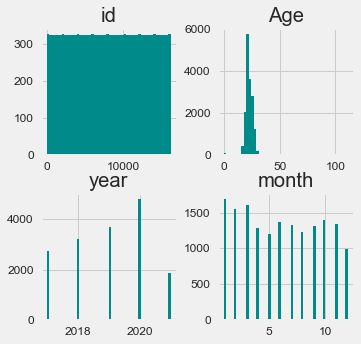

In [125]:
# Quick look at numeric variable distributions
plts = mod_helpline.hist(bins=50, figsize=(5,5),color ='darkcyan')
plt.show()

In [126]:
# Drop age outliers
mod_helpline = mod_helpline[(mod_helpline['Age']>15) & (mod_helpline['Age']<30)]

Text(0.5, 0, 'Gender')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Gender Counts')

[Text(0, 0, 'Female'), Text(1, 0, 'Male'), Text(2, 0, 'Other')]

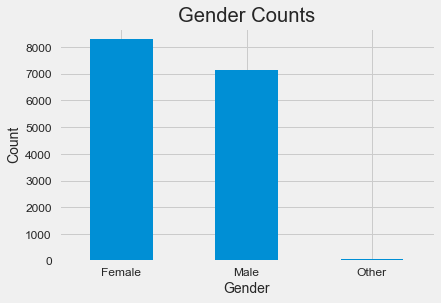

In [38]:
# Gender totals
by_gender = mod_helpline.groupby('Gender')
ax = by_gender.size().plot(kind='bar')
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Gender Counts")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

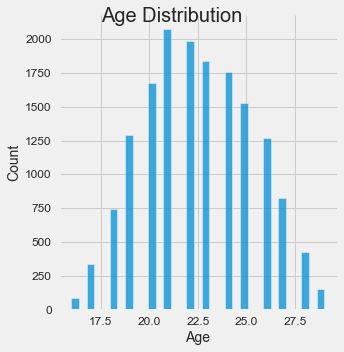

In [128]:
# Age Distribution
ax = sns.displot(mod_helpline['Age'], kde = False)
ax.set_axis_labels('Age', 'Count')
title = ax.fig.suptitle('Age Distribution',
                  fontsize=20)

Text(0.5, 1.0, 'Age Distribution by Gender')

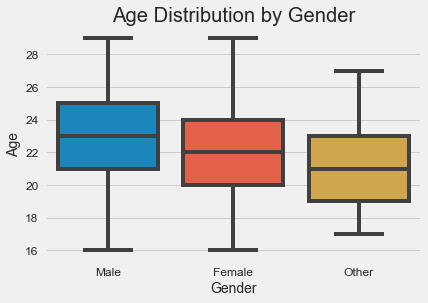

In [129]:
# Age distribution by gender
sns.boxplot(x = "Gender", y = "Age", data=mod_helpline).set_title('Age Distribution by Gender')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Year')

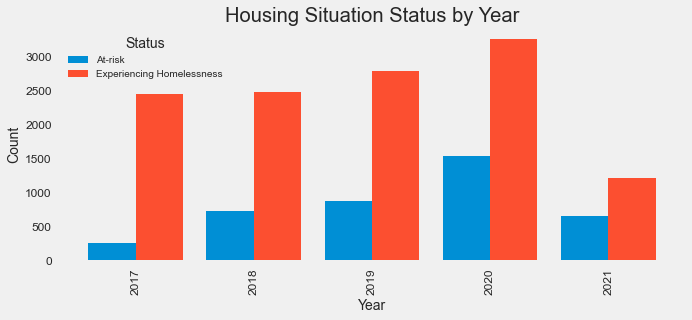

In [41]:
# Experiencing vs at risk counts by year
home_year = mod_helpline.groupby(['year', 'Status'])

# Plot data
home = home_year.size().unstack().plot(kind='bar', figsize=(10,4), width=.8, grid=False)
title = home.set_title("Housing Situation Status by Year")
home.set_ylabel("Count")
home.set_xlabel("Year")

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Housing Situation')

Text(0.5, 1.0, 'Top 10 Most Common Housing Situations')

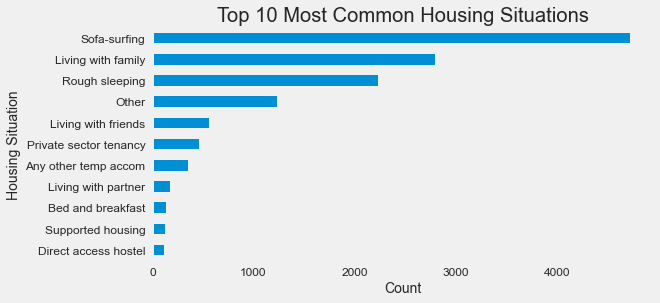

In [131]:
# Get counts to housing situation
sit_count = pd.DataFrame(mod_helpline.groupby(['Housing Situation']).count()['id']).sort_values(by='id', ascending = False)

# Create final data frame- only include top 10 situations
top_sit = pd.DataFrame(sit_count[sit_count['id'] > 99]).sort_values(by='id', ascending = True)

# Plot data
fig, ax = plt.subplots(figsize=(8,4))
ax= top_sit['id'].plot(ax=ax, kind='barh',grid=False)
ax.set_xlabel("Count")
ax.set_ylabel("Housing Situation")
ax.set_title("Top 10 Most Common Housing Situations")

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Reasons')

Text(0.5, 1.0, 'Top 10 Most Common Reasons for Contacting Helpline')

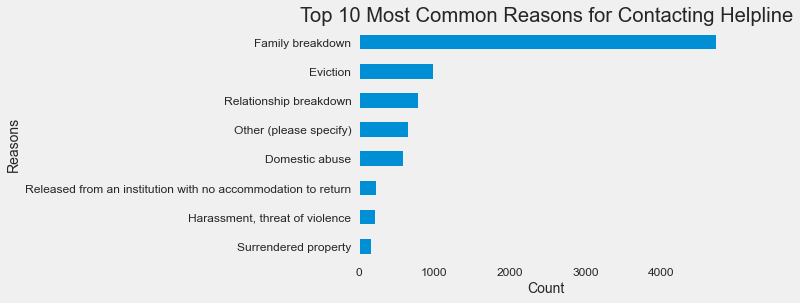

In [132]:
# Get counts to housing situation
cause_count = pd.DataFrame(mod_helpline.groupby(['Main cause of homelessness']).count()['id']).sort_values(by='id', ascending = False)

# Create final data frame- only include top 10 causes
top_cause = pd.DataFrame(cause_count[cause_count['id'] > 87]).sort_values(by='id', ascending = True)

# Plot data
fig, ax = plt.subplots(figsize=(6,4))
ax= top_cause['id'].plot(ax=ax, kind='barh',grid=False)
ax.set_xlabel("Count")
ax.set_ylabel("Reasons")
ax.set_title("Top 10 Most Common Reasons for Contacting Helpline")

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Region')

Text(0.5, 1.0, 'Regional Breakdown')

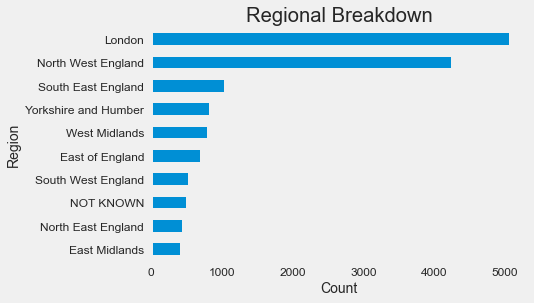

In [133]:
# Get counts to housing situation
reg_count = pd.DataFrame(mod_helpline.groupby(['Region']).count()['id']).sort_values(by='id', ascending = False)

# Create final data frame- only include top 10 regions
top_reg = pd.DataFrame(reg_count[reg_count['id'] > 200]).sort_values(by='id', ascending = True)

# Plot data
fig, ax = plt.subplots(figsize=(6,4))
ax= top_reg['id'].plot(ax=ax, kind='barh',grid=False)
ax.set_xlabel("Count")
ax.set_ylabel("Region")
ax.set_title("Regional Breakdown")

## Extract Features for K-Prototypes Clustering Model <a class="anchor" id="twoc"></a>

I chose to use the K-Prototypes model in the section because it can handle both categorical and numeric features. The pre-processing involves standard normalization of the numeric features, outlier removal, and removing rows with null values.

In [ ]:
# Eliminate rows where cause of and at risk at columns are both null
mod_helpline = mod_helpline[(mod_helpline['Main cause of homelessness'].notnull()) | (mod_helpline['At risk of Homelessness due to'].notnull())]

# Combine cause for experiencing and at risk of homelessness into one column
mod_helpline['Main cause of homelessness'].fillna(mod_helpline['At risk of Homelessness due to'], inplace=True)

# Drop records with null values in the following columns 
mod_helpline = mod_helpline[mod_helpline['Housing Situation'].notna()]
mod_helpline = mod_helpline[mod_helpline['Gender'].notna()]
mod_helpline = mod_helpline[mod_helpline['Current Borough YP Is In'].notna()]
mod_helpline = mod_helpline[mod_helpline['Region'].notna()]

In [16]:
# Impute median for null values in age column
# Check median value for columns with null values
statistics.median(mod_helpline.Age)

mod_helpline["Age"].fillna(22.0, inplace=True)

22.0

In [17]:
# Drop columns with too many null values  
mod_helpline = mod_helpline.drop(columns=['Timeline Start Date','Recurring Case of Homelessness','At risk of Homelessness due to',
                                         'Priority need','Is SWEP open in this council area?','Immigration Status'
                                         ,'Main cause of homelessness sub-category','Housing situation details',
                                         'Current Borough YP Is In','year','month','Pre or Post COVID'])

In [18]:
# Check for null values one last time
mod_helpline_pct_null = mod_helpline.isnull().sum() * 100 / len(mod_helpline)
mod_helpline_pct_null

Housing Situation             0.0
Gender                        0.0
Region                        0.0
Main cause of homelessness    0.0
Age                           0.0
Status                        0.0
dtype: float64

In [19]:
mod_helpline.head()
mod_helpline.info()

Housing Situation  Gender              Region  \
1      Living with family    Male                None   
2      Living with family    Male                None   
5  Private sector tenancy  Female                None   
7      Living with family  Female  South East England   
8            Sofa-surfing  Female  South East England   

  Main cause of homelessness   Age                     Status  
1           Family breakdown  21.0                    At-risk  
2     Other (please specify)  27.0                    At-risk  
5                   Eviction  25.0                    At-risk  
7           Family breakdown  19.0  Experiencing Homelessness  
8                   Eviction  22.0  Experiencing Homelessness

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9098 entries, 1 to 14885
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Housing Situation           9098 non-null   object 
 1   Gender                      9098 non-null   object 
 2   Region                      9098 non-null   object 
 3   Main cause of homelessness  9098 non-null   object 
 4   Age                         9098 non-null   float64
 5   Status                      9098 non-null   object 
dtypes: float64(1), object(5)
memory usage: 497.5+ KB


In [22]:
# Change data type to category for categorical features
mod_helpline["Housing Situation"] = mod_helpline["Housing Situation"].astype('category')
mod_helpline["Gender"] = mod_helpline["Gender"].astype('category')
mod_helpline["Region"] = mod_helpline["Region"].astype('category')
mod_helpline["Main cause of homelessness"] = mod_helpline["Main cause of homelessness"].astype('category')
mod_helpline["Status"] = mod_helpline["Status"].astype('category')

In [23]:
# Create cat codes set for cluster visualiztion purposes later on
mod_helpline["Housing Situation_cat"] = mod_helpline["Housing Situation"].cat.codes.astype('category')
mod_helpline["Gender_cat"] = mod_helpline["Gender"].cat.codes.astype('category')
mod_helpline["Region_cat"] = mod_helpline["Region"].cat.codes.astype('category')
mod_helpline["Main cause of homelessness_cat"] = mod_helpline["Main cause of homelessness"].cat.codes.astype('category')
mod_helpline["Status_cat"] = mod_helpline["Status"].cat.codes.astype('category')
mod_helpline.head()

Housing Situation  Gender              Region  \
1      Living with family    Male                None   
2      Living with family    Male                None   
5  Private sector tenancy  Female                None   
7      Living with family  Female  South East England   
8            Sofa-surfing  Female  South East England   

  Main cause of homelessness   Age                     Status  \
1           Family breakdown  21.0                    At-risk   
2     Other (please specify)  27.0                    At-risk   
5                   Eviction  25.0                    At-risk   
7           Family breakdown  19.0  Experiencing Homelessness   
8                   Eviction  22.0  Experiencing Homelessness   

  Housing Situation_cat Gender_cat Region_cat Main cause of homelessness_cat  \
1                    11          1          4                              4   
2                    11          1          4                              9   
5                    19          0          4                              3   
7                    11          0          7                              4   
8                    23          0          7                              3   

  Status_cat  
1          0  
2          0  
5          0  
7          1  
8          1

In [27]:
# Standardizing all the numerical variables
Num_features=mod_helpline.select_dtypes('float64').columns
mod_helpline[Num_features]=preprocessing.MinMaxScaler().fit_transform(mod_helpline[Num_features])
mod_helpline.head()

Housing Situation  Gender              Region  \
1      Living with family    Male                None   
2      Living with family    Male                None   
5  Private sector tenancy  Female                None   
7      Living with family  Female  South East England   
8            Sofa-surfing  Female  South East England   

  Main cause of homelessness       Age                     Status  \
1           Family breakdown  0.384615                    At-risk   
2     Other (please specify)  0.846154                    At-risk   
5                   Eviction  0.692308                    At-risk   
7           Family breakdown  0.230769  Experiencing Homelessness   
8                   Eviction  0.461538  Experiencing Homelessness   

  Housing Situation_cat Gender_cat Region_cat Main cause of homelessness_cat  \
1                    11          1          4                              4   
2                    11          1          4                              9   
5                    19          0          4                              3   
7                    11          0          7                              4   
8                    23          0          7                              3   

  Status_cat  
1          0  
2          0  
5          0  
7          1  
8          1

## Run K-Prototypes Model <a class="anchor" id="twod"></a>

The process for running the K-Prototypes model is similar to a standard K-means clustering process, with the main difference being that the elbow method process for selecting an optimal k using a cost function as the determining metric, as opposed to sum of squared distances. This is because of the presence of categorical features and is a drawback of this model, as it cannot be directly compared to other clustering models that use distance-based evaluation criteria.

In [28]:
# Code Source for k prototypes clustering: https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

# Get the position of categorical columns
catColumnsPos = [mod_helpline.columns.get_loc(col) for col in list(mod_helpline.select_dtypes('category').columns)]
print('Categorical columns           : {}'.format(list(mod_helpline.select_dtypes('category').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Housing Situation', 'Gender', 'Region', 'Main cause of homelessness', 'Status', 'Housing Situation_cat', 'Gender_cat', 'Region_cat', 'Main cause of homelessness_cat', 'Status_cat']
Categorical columns position  : [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]


In [29]:
# Convert dataframe to matrix
mod_helplineMatrix = mod_helpline.to_numpy()

In [30]:
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 42)
        kprototype.fit_predict(mod_helplineMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

Cluster initiation: 1


array([1, 1, 1, ..., 0, 0, 1], dtype=uint16)

Cluster initiation: 2


array([2, 2, 2, ..., 0, 0, 2], dtype=uint16)

Cluster initiation: 3


array([3, 3, 2, ..., 1, 2, 3], dtype=uint16)

Cluster initiation: 4


array([0, 0, 0, ..., 3, 4, 0], dtype=uint16)

Cluster initiation: 5


array([1, 1, 2, ..., 4, 0, 2], dtype=uint16)

Cluster initiation: 6


array([3, 3, 0, ..., 4, 2, 6], dtype=uint16)

Cluster initiation: 7


array([0, 0, 5, ..., 6, 3, 5], dtype=uint16)

Cluster initiation: 8


array([2, 2, 0, ..., 5, 4, 8], dtype=uint16)

Cluster initiation: 9


In [31]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})
# Display data frame
df_cost

Cluster         Cost
0        1  5324.704600
1        2  4251.121328
2        3  3623.518877
3        4  3443.171552
4        5  3213.741647
5        6  3134.706364
6        7  2936.472564
7        8  2921.788153
8        9  2799.909193

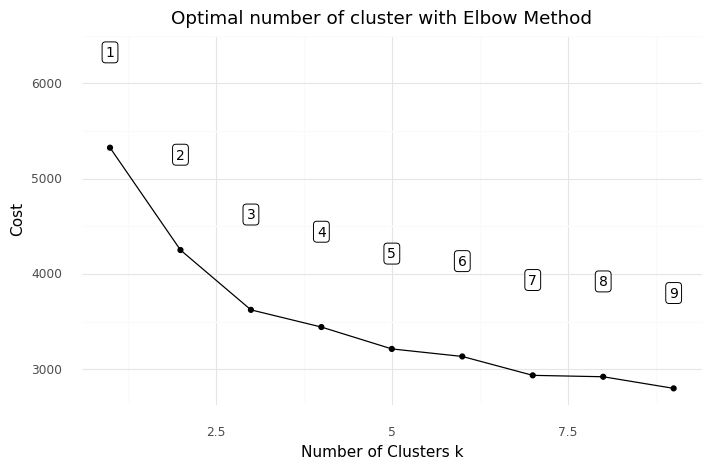

<ggplot: (88135153550)>

In [32]:
# Find optimal k using elbow method
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [34]:
# Fit the cluster for final model with optimal k
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 42)
clusters = kprototype.fit_predict(mod_helplineMatrix, categorical = catColumnsPos)

## K-Prototypes Cluster Analysis <a class="anchor" id="twoe"></a>

This section summarizes the modal and mean values of each feature by cluster and uses distribution plots to visualize the variation between clusters.

In [35]:
# Cluster interpretation
# Add the cluster to the dataframe
mod_helpline['Cluster Labels'] = kprototype.labels_
mod_helpline['Segment'] = mod_helpline['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
mod_helpline['Segment'] = mod_helpline['Segment'].astype('category')
mod_helpline['Segment'] = mod_helpline['Segment'].cat.reorder_categories(['First','Second','Third'])
# Show the first 5 rows
mod_helpline.head()

Housing Situation  Gender              Region  \
1      Living with family    Male                None   
2      Living with family    Male                None   
5  Private sector tenancy  Female                None   
7      Living with family  Female  South East England   
8            Sofa-surfing  Female  South East England   

  Main cause of homelessness       Age                     Status  \
1           Family breakdown  0.384615                    At-risk   
2     Other (please specify)  0.846154                    At-risk   
5                   Eviction  0.692308                    At-risk   
7           Family breakdown  0.230769  Experiencing Homelessness   
8                   Eviction  0.461538  Experiencing Homelessness   

  Housing Situation_cat Gender_cat Region_cat Main cause of homelessness_cat  \
1                    11          1          4                              4   
2                    11          1          4                              9   
5                    19          0          4                              3   
7                    11          0          7                              4   
8                    23          0          7                              3   

  Status_cat  Cluster Labels Segment  
1          0               2   Third  
2          0               2   Third  
5          0               2   Third  
7          1               2   Third  
8          1               1  Second

In [37]:
# Create data frame with modal and mean values of relevant features for each cluster
mod_helpline.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
mod_helpline.groupby('Segment').agg(
    {
        'Housing Situation': lambda x: x.value_counts().index[0],
        'Gender': lambda x: x.value_counts().index[0],
        'Region': lambda x: x.value_counts().index[0],
        'Main cause of homelessness': lambda x: x.value_counts().index[0],
        'Age': 'mean',
        'Status': lambda x: x.value_counts().index[0]
    }
).reset_index()

Segment   Housing Situation  Gender              Region  \
0   First        Sofa-surfing    Male              London   
1  Second        Sofa-surfing  Female              London   
2   Third  Living with family  Female  North West England   

  Main cause of homelessness       Age                     Status  
0           Family breakdown  0.548056  Experiencing Homelessness  
1           Family breakdown  0.501138  Experiencing Homelessness  
2           Family breakdown  0.417513                    At-risk

0    3255
1    3009
2    2834
Name: Segment, dtype: int64


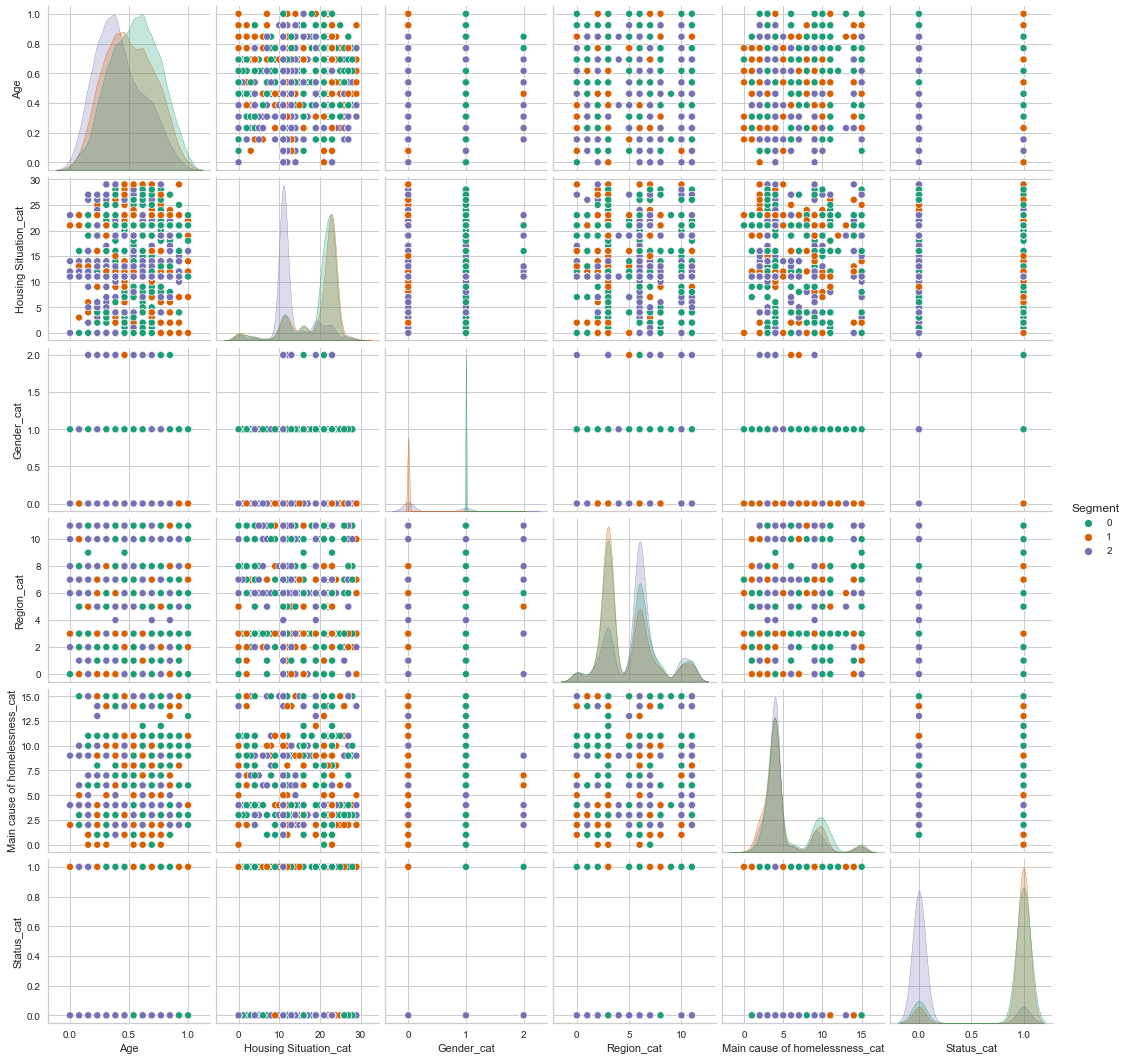

In [38]:
# Visualize K-Prototype clustering using PCA projected Data
# Code Source: https://www.kaggle.com/rohanadagouda/unsupervised-learning-using-k-prototype-and-dbscan
df=pd.DataFrame(cat_helpline)
df['Housing Situation_cat']=df['Housing Situation_cat'].astype('float')
df['Gender_cat']=df['Gender_cat'].astype('float')
df['Region_cat']=df['Region_cat'].astype('float')
df['Status_cat']=df['Status_cat'].astype('float')
df['Main cause of homelessness_cat']=df['Main cause of homelessness_cat'].astype('float')
df['Segment']=clusters
print(df['Segment'].value_counts())
sns.pairplot(df,hue='Segment',palette='Dark2',diag_kind='kde')

<AxesSubplot:xlabel='Age', ylabel='Density'>

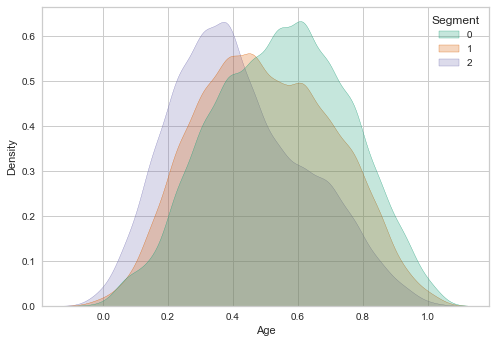

In [45]:
# Age distributions 
sns.kdeplot(data = df, x = 'Age', hue = 'Segment',shade=True,palette='Dark2')

<AxesSubplot:xlabel='Gender_cat', ylabel='Density'>

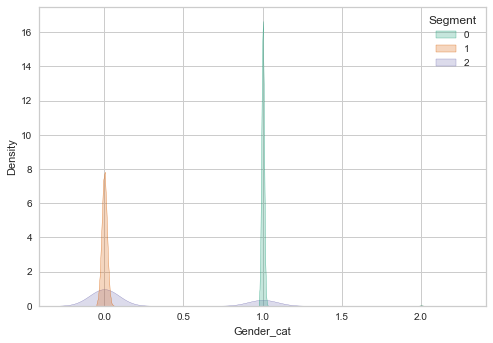

In [40]:
# Gender distributions 
sns.kdeplot(data = df, x = 'Gender_cat', hue = 'Segment',shade=True,palette='Dark2')

<AxesSubplot:xlabel='Region_cat', ylabel='Density'>

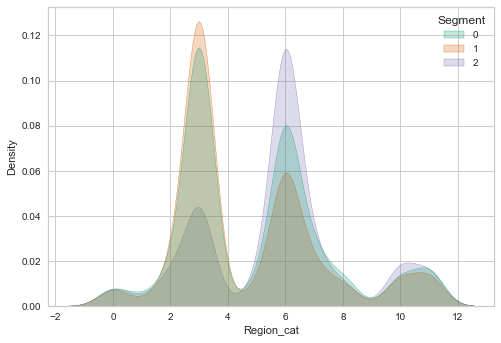

In [41]:
# Region distributions 
sns.kdeplot(data = df, x = 'Region_cat', hue = 'Segment',shade=True,palette='Dark2')

<AxesSubplot:xlabel='Main cause of homelessness_cat', ylabel='Density'>

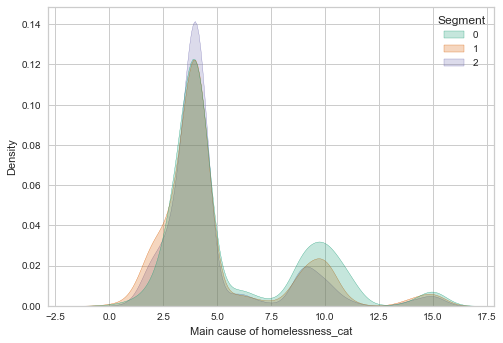

In [42]:
# Cause of homelessness distributions
sns.kdeplot(data = df, x = 'Main cause of homelessness_cat', hue = 'Segment',shade=True,palette='Dark2')

<AxesSubplot:xlabel='Status_cat', ylabel='Density'>

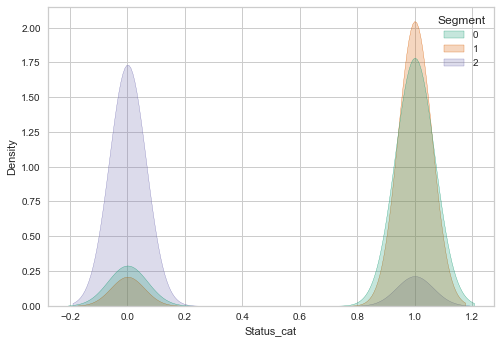

In [43]:
# Housing staus distributions
sns.kdeplot(data = df, x = 'Status_cat', hue = 'Segment',shade=True,palette='Dark2')

# Free Text Features <a class="anchor" id="three"></a>

This section consists of the data cleaning, feature extraction, and model running and evaluation for the free text features of the helpline and enquiry datasets, as well as a combined dataset with text from both. The free text is both datasets is derived from a column in which a Centrepoint representative records the notes from the conversation with a young person or advocate on the helpline crisis line.

## Prep Data Free Text Clustering Models <a class="anchor" id="threea"></a>

This section uses standard NLP pre-preprocessing methods to prepare the data for the models. This is tokenization, removing stop word, stemming, lemmatization, and spell checking. For the helpline data set, I combined multiple free text columns to form a singular document. 

In [4]:
# Define functions for text pre-processing
# Code Source:https://www.kaggle.com/shubha23/text-processing-pipeline-classification-models

# Create tokens from original text
def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

# Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

# Remove stopewords function
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

# Function to apply stemming to get root words 
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

# Function to apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

# Function to create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

### Helpline Data

In [136]:
# Check for values that should not be inlcluded in the final text data set
helpline['Housing situation details'].value_counts()

Did not disclose                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           204
not disclosed                                                                                                                                                                                                                                                                                                                                                                            

In [137]:
# Replace unkown lables with null values
helpline['Housing situation details'] = helpline['Housing situation details'].replace('Did not disclose', np.nan)
helpline['Housing situation details'] = helpline['Housing situation details'].replace('not disclosed', np.nan)
helpline['Housing situation details'] = helpline['Housing situation details'].replace('not known', np.nan)
helpline['Housing situation details'] = helpline['Housing situation details'].replace('Unknown', np.nan)
helpline['Housing situation details'] = helpline['Housing situation details'].replace('Did not disclose.', np.nan)

In [138]:
# Check for values that should not be inlcluded in the final text data set
helpline['Timeline Event Notes'].value_counts()

See inquiry                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [139]:
# Replace unkown lables with null values
helpline['Timeline Event Notes'] = helpline['Timeline Event Notes'].replace('See inquiry', np.nan)
helpline['Timeline Event Notes'] = helpline['Timeline Event Notes'].replace('See enquiry', np.nan)
helpline['Timeline Event Notes'] = helpline['Timeline Event Notes'].replace('Referred to CCP', np.nan)
helpline['Timeline Event Notes'] = helpline['Timeline Event Notes'].replace('See enquiry', np.nan)
helpline['Timeline Event Notes'] = helpline['Timeline Event Notes'].replace('Referred to Centrepoint CCP', np.nan)

In [140]:
# Create df of just text column, with only non-null values
helpline_text = helpline[['Housing situation details','Timeline Event Notes']].reset_index()
helpline_text = helpline_text[helpline_text['Housing situation details'].notna() | helpline_text['Timeline Event Notes'].notna()]
helpline_text['Housing situation details']=helpline_text['Housing situation details'].astype('string')
helpline_text['Timeline Event Notes']=helpline_text['Timeline Event Notes'].astype('string')

# Concat the two text columns to make final data set
helpline_text = helpline_text.fillna('')
helpline_text["text"] = helpline_text[['Housing situation details','Timeline Event Notes']].agg(' '.join, axis=1)

helpline_text.head()

index                          Housing situation details  \
1       1  YP has been staying with relatives in Europe f...   
2       2       He had no job and went to Malaysia to settle   
13     13  Was in a refuse but had to leave due to someon...   
17     17  YP is currently sleeping in their cousin's car...   
18     18  Living with ex - partner's mum, so still expos...   

   Timeline Event Notes                                               text  
1                        YP has been staying with relatives in Europe f...  
2                            He had no job and went to Malaysia to settle   
13                       Was in a refuse but had to leave due to someon...  
17                       YP is currently sleeping in their cousin's car...  
18                       Living with ex - partner's mum, so still expos...

In [142]:
# Spell check for helpline data
helpline_text["text"] = helpline_text["text"].str.replace('YP', 'young person')
helpline_text["text"] = helpline_text["text"].str.replace('yp', 'young person')

spell = Speller(lang='en')
helpline_text["text"] = [' '.join([spell(i) for i in x.split()]) for x in helpline_text['text']]
helpline_text

index                          Housing situation details  \
1          1  YP has been staying with relatives in Europe f...   
2          2       He had no job and went to Malaysia to settle   
13        13  Was in a refuse but had to leave due to someon...   
17        17  YP is currently sleeping in their cousin's car...   
18        18  Living with ex - partner's mum, so still expos...   
...      ...                                                ...   
16281  16281  Did not disclose - Hi my name is Patrick and i...   
16290  16290  Sofa surfing for two months can't afford priva...   
16306  16306  I am currently living on the isle of wight and...   
16307  16307  Hello 
I’m living on the streets in Brighton ...   
16308  16308  Been trying to get out of the area for a long ...   

      Timeline Event Notes                                               text  
1                           young person has been staying with relatives i...  
2                                He had no job and went to Malaysia to settle  
13                          Was in a refuse but had to leave due to someon...  
17                          young person is currently sleeping in their co...  
18                          Living with ex - partner's mum, so still expos...  
...                    ...                                                ...  
16281                       Did not disclose - Hi my name is Patrick and i...  
16290                       Sofa surfing for two months can't afford priva...  
16306                       I am currently living on the isle of right and...  
16307                       Hello I’m living on the streets in Brighton at...  
16308                       Been trying to get out of the area for a long ...  

[6672 rows x 4 columns]

In [5]:
# export and reimport spell checked data to save time
helpline_text.to_excel(r'C:/Users/geaco/OneDrive/Documents/Dissertation/Data/Helpline_checked.xlsx', index = False)

NameError: name 'helpline_text' is not defined

In [7]:
# Assign Excel files to appropriate DataFrames

# Helpline Data
helpline_text = pd.read_excel('C:/Users/geaco/OneDrive/Documents/Dissertation/Data/Helpline_checked.xlsx')
helpline_text = pd.DataFrame(helpline_text[['index','spellcheck']])

#convert spellchecked text to string
helpline_text['text']=helpline_text['spellcheck'].astype('string')

In [8]:
# Prep helpline text using pre-defined functions

# remove young person, enquiry, and inquiry due to high volume of useage
helpline_text["text"] = helpline_text["text"].str.replace('young person', '')
helpline_text["text"] = helpline_text["text"].str.replace('inquiry', '')
helpline_text["text"] = helpline_text["text"].str.replace('enquiry', '')

# lowercase
helpline_text["text"] = helpline_text["text"].str.lower()

# remove numbers
helpline_text["text"] = helpline_text["text"].str.replace('\d+', '')

# remove punctuation
helpline_text["text"] = helpline_text["text"].str.replace('[^\w\s]','')

# create tokens from sentences
helpline_text['tokens'] = helpline_text['text'].apply(lambda msg : tokenize(msg))

# remove tokens with less than 3 words
helpline_text['larger_tokens'] = helpline_text['tokens'].apply(lambda x : remove_small_words(x))

# remove stopwords
helpline_text['clean_tokens'] = helpline_text['larger_tokens'].apply(lambda x : remove_stopwords(x))

# stem words
helpline_text['stem_words'] = helpline_text['clean_tokens'].apply(lambda wrd: stemming(wrd))

# lemmatize words
helpline_text['lemma_words'] = helpline_text['clean_tokens'].apply(lambda x : lemmatize(x))

# create final clean sentences
helpline_text['final_text'] = helpline_text['lemma_words'].apply(lambda x : return_sentences(x))
helpline_text.head()

index                                         spellcheck  \
0      1  young person has been staying with relatives i...   
1      2       He had no job and went to Malaysia to settle   
2     13  Was in a refuse but had to leave due to someon...   
3     17  young person is currently sleeping in their co...   
4     18  Living with ex - partner's mum, so still expos...   

                                                text  \
0   has been staying with relatives in europe for...   
1       he had no job and went to malaysia to settle   
2  was in a refuse but had to leave due to someon...   
3   is currently sleeping in their cousins car af...   
4  living with ex  partners mum so still exposed ...   

                                              tokens  \
0  [, has, been, staying, with, relatives, in, eu...   
1  [he, had, no, job, and, went, to, malaysia, to...   
2  [was, in, a, refuse, but, had, to, leave, due,...   
3  [, is, currently, sleeping, in, their, cousins...   
4  [living, with, ex, partners, mum, so, still, e...   

                                       larger_tokens  \
0  [been, staying, with, relatives, europe, years...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, their, cousins, after, b...   
4  [living, with, partners, still, exposed, behav...   

                                        clean_tokens  \
0  [staying, relatives, europe, years, family, br...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, cousins, evicted, stonep...   
4  [living, partners, still, exposed, behaviour, ...   

                                          stem_words  \
0  [stay, rel, europ, year, famili, breakdown, ta...   
1                            [went, malaysia, settl]   
2              [refus, leav, someon, turn, accommod]   
3  [current, sleep, cousin, evict, stonepillow, h...   
4  [live, partner, still, expos, behaviour, want,...   

                                         lemma_words  \
0  [staying, relative, europe, year, family, brea...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, cousin, evicted, stonepi...   
4  [living, partner, still, exposed, behaviour, w...   

                                          final_text  
0  staying relative europe year family breakdown ...  
1                               went malaysia settle  
2         refuse leave someone turning accommodation  
3  currently sleeping cousin evicted stonepillow ...  
4   living partner still exposed behaviour want soon

### Enquiry Data

In [144]:
# Repeat the prep process for the enquiry data set
# Check for values that should not be inlcluded in the final text data set
enquiry['Enquiry description'].value_counts()

see notes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [145]:
# Replace unkown lables with null values
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('see notes.', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('see notes', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('Please see inform notes.', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('See inform notes.', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('see timeline notes.', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('Please see inform notes', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('See inform notes', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('See timeline notes', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('See timeline', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('No message', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('see TL notes.', np.nan)
enquiry['Enquiry description'] = enquiry['Enquiry description'].replace('See notes on timeline.', np.nan)

In [146]:
# Create df of just text column, with only non-null values
enquiry_text = enquiry['Enquiry description'].reset_index()
enquiry_text = enquiry_text[enquiry_text['Enquiry description'].notna()]
enquiry_text['Enquiry description']=enquiry_text['Enquiry description'].astype('string')
enquiry_text.columns = ['id','case_details']

enquiry_text.head()

id                                       case_details
0   0  Working with a young person who has recently r...
1   1  Her friend is getting evicted in 2 weeks. Live...
2   2  She is working with a yp who is 19 and under t...
3   3  Received call from sister of two young people ...
4   4  Received a call from 3rd party regarding her f...

In [147]:
# Spell check for enquiry

# YP is a common abbreviation for 'young person' in the data, so I am replacing the value for spell checking 
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('YP', 'young person')
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('yp', 'young person')

# Create spell checked data frame
spell = Speller(lang='en')
enquiry_text["case_details"] = [' '.join([spell(i) for i in x.split()]) for x in enquiry_text['case_details']]
enquiry_text

id                                       case_details
0        0  Working with a young person who has recently r...
1        1  Her friend is getting evicted in 2 weeks. Live...
2        2  She is working with a young person who is 19 a...
3        3  Received call from sister of two young people ...
4        4  Received a call from 3rd party regarding her f...
...    ...                                                ...
6927  6927  Received a call from a Dad regarding his son- ...
6928  6928  Not for myself but my boyfriend, he moved to P...
6929  6929  Looking for somewhere for his client to stay t...
6930  6930  Has spoken to Citizens Advice, they advised to...
6931  6931  Email received with completed referral form fo...

[6554 rows x 2 columns]

In [ ]:
# Export and reimport spell checked df to save time
enquiry_text.to_excel(r'C:/Users/geaco/OneDrive/Documents/Dissertation/Data/enquiry_checked.xlsx', index = False)

In [ ]:
# Assign Excel files to appropriate DataFrames

# Enquiry Data
enquiry_text = pd.read_excel('C:/Users/geaco/OneDrive/Documents/Dissertation/Data/enquiry_checked.xlsx')
enquiry_text = pd.DataFrame(enquiry_text[['case_details']])

# Convert spellchecked text to string
enquiry_text['case_details']=enquiry_text['case_details'].astype('string')

In [148]:
# Prep enquiry text using pre-defined functions

# remove young person, enquiry, and inquiry due to high volume of useage
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('young person', '')
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('inquiry', '')
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('enquiry', '')

# lowercase
enquiry_text["case_details"] = enquiry_text["case_details"].str.lower()

# remove numbers
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('\d+', '')

# remove punctuation
enquiry_text["case_details"] = enquiry_text["case_details"].str.replace('[^\w\s]','')

# create tokens from sentences
enquiry_text['tokens'] = enquiry_text["case_details"].apply(lambda msg : tokenize(msg))

# remove tokens with less than 3 words
enquiry_text['larger_tokens'] = enquiry_text['tokens'].apply(lambda x : remove_small_words(x))

# remove stopwords
enquiry_text['clean_tokens'] = enquiry_text['larger_tokens'].apply(lambda x : remove_stopwords(x))

# stem words
enquiry_text['stem_words'] = enquiry_text['clean_tokens'].apply(lambda wrd: stemming(wrd))

#lemmatize words
enquiry_text['lemma_words'] = enquiry_text['clean_tokens'].apply(lambda x : lemmatize(x))

#create final clean sentences
enquiry_text['final_text'] = enquiry_text['lemma_words'].apply(lambda x : return_sentences(x))
enquiry_text.head()

id                                       case_details  \
0   0  working with a  who has recently returned to t...   
1   1  her friend is getting evicted in  weeks lives ...   
2   2  she is working with a  who is  and under threa...   
3   3  received call from sister of two young people ...   
4   4  received a call from rd party regarding her fr...   

                                              tokens  \
0  [working, with, a, who, has, recently, returne...   
1  [her, friend, is, getting, evicted, in, weeks,...   
2  [she, is, working, with, a, who, is, and, unde...   
3  [received, call, from, sister, of, two, young,...   
4  [received, a, call, from, rd, party, regarding...   

                                       larger_tokens  \
0  [working, with, recently, returned, country, a...   
1  [friend, getting, evicted, weeks, lives, with,...   
2  [working, with, under, threat, violence, from,...   
3  [received, call, from, sister, young, people, ...   
4  [received, call, from, party, regarding, frien...   

                                        clean_tokens  \
0  [working, recently, returned, country, fleeing...   
1  [friend, getting, evicted, weeks, lives, going...   
2  [working, threat, violence, brother, home, qui...   
3  [received, call, sister, young, people, living...   
4  [received, call, party, regarding, friend, cou...   

                                          stem_words  \
0  [work, recent, return, countri, flee, gang, vi...   
1  [friend, get, evict, week, live, go, kick, wor...   
2  [work, threat, violenc, brother, home, quit, s...   
3  [receiv, call, sister, young, peopl, live, ove...   
4  [receiv, call, parti, regard, friend, courtney...   

                                         lemma_words  \
0  [working, recently, returned, country, fleeing...   
1  [friend, getting, evicted, week, life, going, ...   
2  [working, threat, violence, brother, home, qui...   
3  [received, call, sister, young, people, living...   
4  [received, call, party, regarding, friend, cou...   

                                          final_text  
0  working recently returned country fleeing gang...  
1  friend getting evicted week life going kicked ...  
2  working threat violence brother home quite ser...  
3  received call sister young people living overc...  
4  received call party regarding friend courtney ...

### Combined helpline and enquiry data sets

In [149]:
# Rename enquiry text column to match helpline
enquiry_text = enquiry_text.rename(columns={"case_details": "text"})

helpline_comb_text = helpline_text[['text']]
enquiry_comb_text = enquiry_text[['text']]

In [150]:
# Concat helpline and enquiry dfs to make one text column
frames = [helpline_comb_text, enquiry_comb_text]
comb_text = pd.concat(frames)
comb_text.head()
comb_text.info()

text
1    has been staying with relatives in europe for...
2        he had no job and went to malaysia to settle
13  was in a refuse but had to leave due to someon...
17   is currently sleeping in their cousins car af...
18  living with ex  partners mum so still exposed ...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13226 entries, 1 to 6931
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13226 non-null  object
dtypes: object(1)
memory usage: 206.7+ KB


In [151]:
# Prep combined text using pre-defined functions

# lowercase
comb_text["text"] = comb_text["text"].str.lower()

# remove numbers
comb_text["text"] = comb_text["text"].str.replace('\d+', '')

# remove punctuation
comb_text["text"] = comb_text["text"].str.replace('[^\w\s]','')

# create tokens from sentences
comb_text['tokens'] = comb_text["text"].apply(lambda msg : tokenize(msg))

# remove tokens with less than 3 words
comb_text['larger_tokens'] = comb_text['tokens'].apply(lambda x : remove_small_words(x))

# remove stopwords
comb_text['clean_tokens'] = comb_text['larger_tokens'].apply(lambda x : remove_stopwords(x))

# stem words
comb_text['stem_words'] = comb_text['clean_tokens'].apply(lambda wrd: stemming(wrd))

# lemmatize words
comb_text['lemma_words'] = comb_text['clean_tokens'].apply(lambda x : lemmatize(x))

# create final clean sentences
comb_text['final_text'] = comb_text['lemma_words'].apply(lambda x : return_sentences(x))
comb_text.head()

text  \
1    has been staying with relatives in europe for...   
2        he had no job and went to malaysia to settle   
13  was in a refuse but had to leave due to someon...   
17   is currently sleeping in their cousins car af...   
18  living with ex  partners mum so still exposed ...   

                                               tokens  \
1   [, has, been, staying, with, relatives, in, eu...   
2   [he, had, no, job, and, went, to, malaysia, to...   
13  [was, in, a, refuse, but, had, to, leave, due,...   
17  [, is, currently, sleeping, in, their, cousins...   
18  [living, with, ex, partners, mum, so, still, e...   

                                        larger_tokens  \
1   [been, staying, with, relatives, europe, years...   
2                            [went, malaysia, settle]   
13   [refuse, leave, someone, turning, accommodation]   
17  [currently, sleeping, their, cousins, after, b...   
18  [living, with, partners, still, exposed, behav...   

                                         clean_tokens  \
1   [staying, relatives, europe, years, family, br...   
2                            [went, malaysia, settle]   
13   [refuse, leave, someone, turning, accommodation]   
17  [currently, sleeping, cousins, evicted, stonep...   
18  [living, partners, still, exposed, behaviour, ...   

                                           stem_words  \
1   [stay, rel, europ, year, famili, breakdown, ta...   
2                             [went, malaysia, settl]   
13              [refus, leav, someon, turn, accommod]   
17  [current, sleep, cousin, evict, stonepillow, h...   
18  [live, partner, still, expos, behaviour, want,...   

                                          lemma_words  \
1   [staying, relative, europe, year, family, brea...   
2                            [went, malaysia, settle]   
13   [refuse, leave, someone, turning, accommodation]   
17  [currently, sleeping, cousin, evicted, stonepi...   
18  [living, partner, still, exposed, behaviour, w...   

                                           final_text  
1   staying relative europe year family breakdown ...  
2                                went malaysia settle  
13         refuse leave someone turning accommodation  
17  currently sleeping cousin evicted stonepillow ...  
18   living partner still exposed behaviour want soon

## Run Free Text Clustering Models <a class="anchor" id="threec"></a>

This section uses a standard k-means process to run and evaluate each clustering model. The process involves first generating the vectors or word embeddings that will be fitted to the k-mean models, then finds the optimal k via the elbow method and silhouette score analysis, visualizes each optimal model clusters using PCA, and finally evaluates each optimal model using silhouette, Davies-Bouldin, and Calinski-Harabasz scores. I evaluated four models in this section. I chose to train the data on TF-IDF and Doc2Vec models as they are routinely found in the literature of unsupervised clustering modeling, and I chose to use transfer learning and test the data on the mp-net and distill roberta models because research has found them to be the highest performing variations of the ROBERTA model for natural language processing and clustering, specifically.

### TF-IDF <a class="anchor" id="threeci"></a>

### Helpline

In [9]:
# Code Source: https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d
# Convert text column to list
help_text_list = helpline_text["final_text"].tolist()
# vectorize using Tfidf
vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
X_help = vectorizer.fit_transform(help_text_list)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

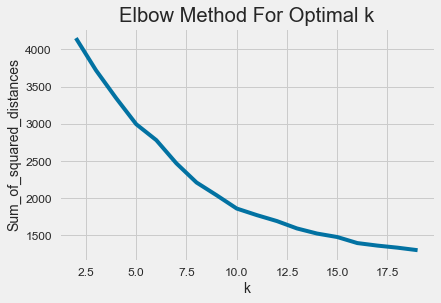

In [153]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(X_help)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

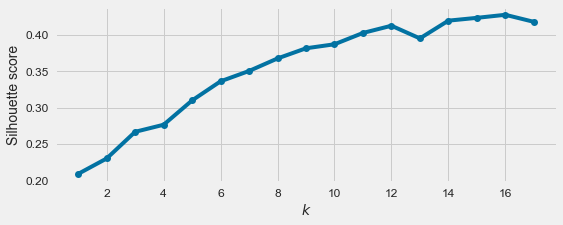

In [154]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_help)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(X_help, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=10)

                                                  title  cluster
2643  currently staying sister asked leave today now...        0
1941  abdulla advised week since evicted last proper...        0
5453  kieran suffered relation breakdown left proper...        0
626   currently rough sleeping near emblem stadium a...        0
6423  currently staying friend temporarily following...        0
...                                                 ...      ...
857   alicia explained moved around place said lived...        9
6286     provided social service told leave coronavirus        9
4768  trained relationship working looking guidance ...        9
6268  currently life private rented property sole na...        9
2816         currently living parent state asking leave        9

[6896 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

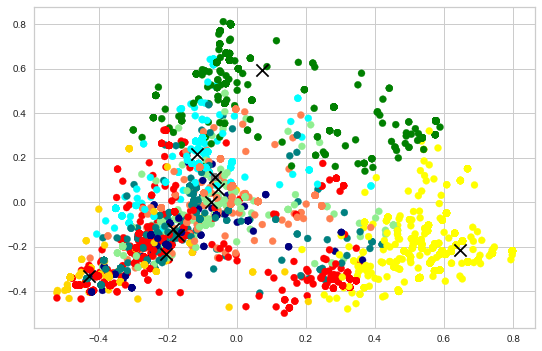

In [11]:
# Input true k based on previous methods and run final model
true_k = 10
td_help = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
td_help.fit(X_help)
td_help_labels=td_help.labels_
td_help_cl=pd.DataFrame(list(zip(helpline_text["final_text"],td_help_labels)),columns=['title','cluster'])
print(td_help_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2, random_state=0)
datapoint = pca.fit_transform(X_help.toarray())
plt.figure
label1 = ["red", "gray", "yellow", "coral","gold",'lightgreen','green','teal','cyan','navy','purple','black','deeppink','tan']
color = [label1[i] for i in td_help_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = td_help.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [257]:
# Evaluation metrics
# silhouette score
print(silhouette_score(X_help, td_help_labels))

# db and ch score
X_help_arr = X_help.toarray()
db_index = davies_bouldin_score(X_help_arr, td_help_labels)
ch_index = calinski_harabasz_score(X_help_arr, td_help_labels)
print(db_index)
print(ch_index)

0.3655767818325459
1.1624291625734327
1143.3364589184216


### Enquiry

In [155]:
# Convert text column to list
enq_text_list = enquiry_text["final_text"].tolist()
# vectorize using Tfidf
vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
X_enq = vectorizer.fit_transform(enq_text_list)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

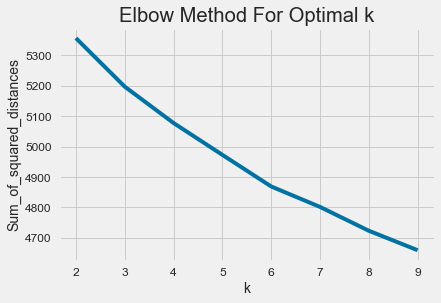

In [156]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(X_enq)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

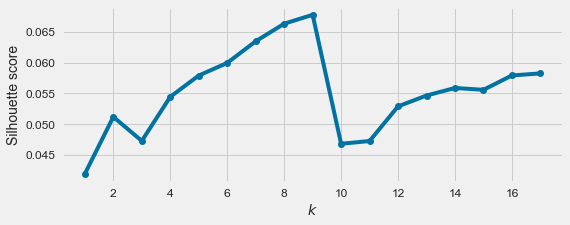

In [157]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_enq)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(X_enq, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200)

                                                  title  cluster
3276    homeless need home wondering whether could help        0
2370  professional calling regarding supporting goin...        0
2371  professional calling regarding supporting goin...        0
5660  adidas called explained trying find accommodat...        0
2377             terri emailed headline evicted nowhere        0
...                                                 ...      ...
2984  call stated rough sleeping family breakdown be...        7
5462  received call friend staying around month land...        7
5461  called explained currently risk homelessness s...        7
2971  call shannon currently rough sleeping aged par...        7
0     working recently returned country fleeing gang...        7

[6554 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

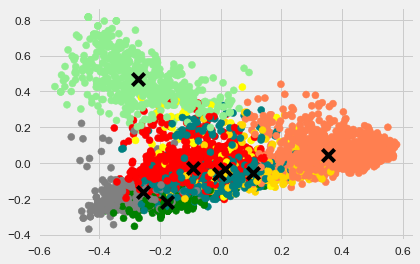

In [165]:
# Imput true k based on previous methods and run final model
true_k = 8
td_enq = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
td_enq.fit(X_enq)
td_enq_labels=td_enq.labels_
td_enq_cl=pd.DataFrame(list(zip(enquiry_text["final_text"],td_enq_labels)),columns=['title','cluster'])
print(td_enq_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2, random_state=0)
datapoint = pca.fit_transform(X_enq.toarray())
plt.figure
label1 = ["red", "gray", "yellow", "coral","gold",'lightgreen','green','teal','cyan','navy','purple','black','deeppink','tan']
color = [label1[i] for i in td_enq_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = td_enq.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [166]:
# Evaluation metrics
# silhouette
print(silhouette_score(X_enq, td_enq_labels))

# db and ch score
X_enq_arr = X_enq.toarray()
db_index = davies_bouldin_score(X_enq_arr, td_enq_labels)
ch_index = calinski_harabasz_score(X_enq_arr, td_enq_labels)
print(db_index)
print(ch_index)

0.060317751697513924
3.603825501956509
178.3841076903627


### Combined

In [158]:
# Convert text column to list
comb_text_list = comb_text["final_text"].tolist()
# Vectorize using Tfidf
vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
X_comb = vectorizer.fit_transform(comb_text_list)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

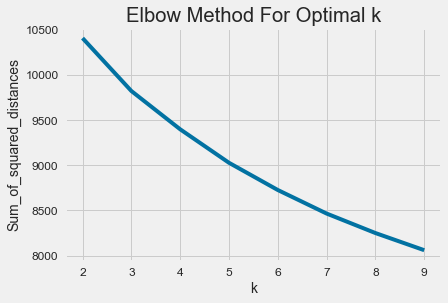

In [162]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(X_comb)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

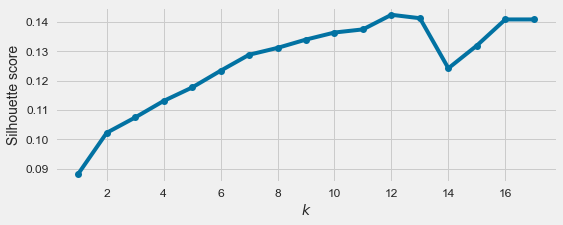

In [160]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_comb)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(X_comb, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=12)

                                                  title  cluster
3276    homeless need home wondering whether could help        0
869   regard called advise prince trust concern rede...        0
5106  call housing association relation vulnerable s...        0
5109  duty refer received rusholme centre limited in...        0
873   hoping might information service provide could...        0
...                                                 ...      ...
1878           kicked flat wondering advice many thanks       11
1875  lost home council wont help oxford support sle...       11
525   calling behalf former unaccompanied child erit...       11
1890  partner pregnant caller signpost flintshire so...       11
6553  email received completed referral form hello a...       11

[6554 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

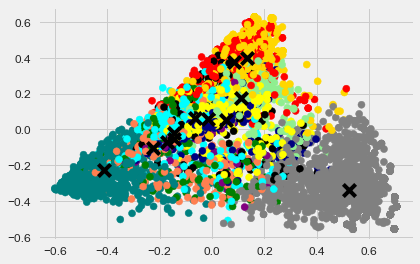

In [167]:
# Imput true k based on previous methods and run final model
true_k = 12
td_comb = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
td_comb.fit(X_comb)
td_comb_labels=td_comb.labels_
td_comb_cl=pd.DataFrame(list(zip(enquiry_text["final_text"],td_comb_labels)),columns=['title','cluster'])
print(td_comb_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2, random_state=0)
datapoint = pca.fit_transform(X_comb.toarray())
plt.figure
label1 = ["red", "gray", "yellow", "coral","gold",'lightgreen','green','teal','cyan','navy','purple','black','deeppink','tan']
color = [label1[i] for i in td_comb_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = td_comb.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [168]:
# Evaluation metrics
# silhouette
print(silhouette_score(X_comb, td_comb_labels))

# db and ch score
X_comb_arr = X_comb.toarray()
db_index = davies_bouldin_score(X_comb_arr, td_comb_labels)
ch_index = calinski_harabasz_score(X_comb_arr, td_comb_labels)
print(db_index)
print(ch_index)

0.13066088120037428
2.6713571796511544
563.6527930521246


### Doc2Vec <a class="anchor" id="threecii"></a>

### Helpline

In [169]:
# Code Source: https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61
# Create vectors for model training
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_help = []
j=0
for em in helpline_text["final_text"].values:
    all_content_help.append(LabeledSentence1(em,[j]))
    j+=1
print("Number of texts processed: ", j)

Number of texts processed:  6672


In [170]:
# Define parameters for doc2vec model
d2v_model_help = Doc2Vec(all_content_help, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)

# Train model
d2v_model_help.train(all_content_help, total_examples=d2v_model_help.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

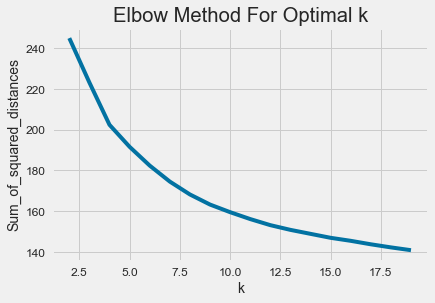

In [171]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(d2v_model_help.dv.vectors)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

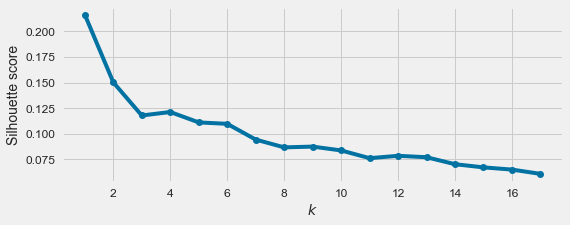

In [172]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(d2v_model_help.dv.vectors)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(d2v_model_help.dv.vectors, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=3)

                                                  title  cluster
5508  sofa surfing around week kicked family home st...        0
2369  moved recently caravan verbal agreement landlo...        0
2370                    living family asked leave today        0
2371  currently life parent state able continue livi...        0
2372                                      evicted today        0
...                                                 ...      ...
4892                                     staying friend        2
4076                           staying friend past year        2
1905                                               soon        2
4628                                     living partner        2
1918                                            specify        2

[6672 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

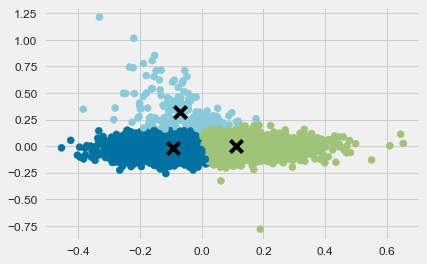

In [195]:
# Imput true k based on previous methods and run final model
true_k = 3
d2v_help = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
d2v_help.fit(d2v_model_help.dv.vectors)
d2v_help_labels=d2v_help.labels_
d2v_help_cl=pd.DataFrame(list(zip(helpline_text["final_text"],d2v_help_labels)),columns=['title','cluster'])
print(d2v_help_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(d2v_model_help.dv.vectors)
datapoint = pca.transform(d2v_model_help.dv.vectors)
plt.figure
label1 = ["b", "g", "c", "r"]
color = [label1[i] for i in d2v_help_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = d2v_help.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()


In [196]:
# Evaluation metrics
# silhouette
print(silhouette_score(d2v_model_help.dv.vectors, d2v_help_labels))

# db and ch score
db_index = davies_bouldin_score(d2v_model_help.dv.vectors, d2v_help_labels)
ch_index = calinski_harabasz_score(d2v_model_help.dv.vectors, d2v_help_labels)
print(db_index)
print(ch_index)

0.21609432
1.3971386243145296
1359.9563502145245


### Enquiry

In [173]:
# Generate vectors for model training
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_enq = []
j=0
for em in enquiry_text["final_text"].values:
    all_content_enq.append(LabeledSentence1(em,[j]))
    j+=1
print("Number of texts processed: ", j)

Number of texts processed:  6554


In [174]:
# Define parameters for Doc2vec model
d2v_model_enq = Doc2Vec(all_content_enq, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)

# Train model
d2v_model_enq.train(all_content_enq, total_examples=d2v_model_enq.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

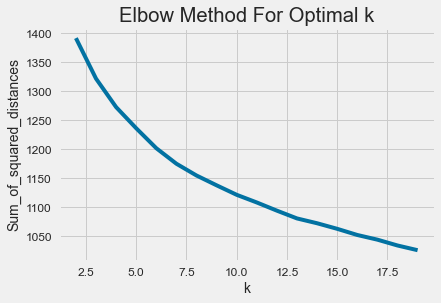

In [175]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(d2v_model_enq.dv.vectors)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

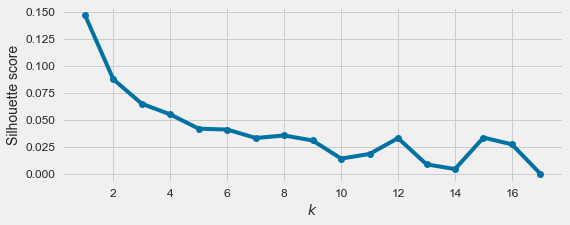

In [176]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(d2v_model_enq.dv.vectors)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(d2v_model_enq.dv.vectors, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=3)

                                                  title  cluster
0     working recently returned country fleeing gang...        0
3418  call charming stated centre calling homeless w...        0
3420  getting support agency tried countless time do...        0
3421  call support worker college stated homeless si...        0
3422  june advised staying cousin homeless tomorrow ...        0
...                                                 ...      ...
747   currently supporting refugee narrow evicted to...        2
5115  webcast transcript laura bellagent natalie you...        2
746   rapid aware colleague working around asylum cl...        2
2857  maya suffers mental health issue bipolar curre...        2
2547  whilst writing email jodie called back called ...        2

[6554 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

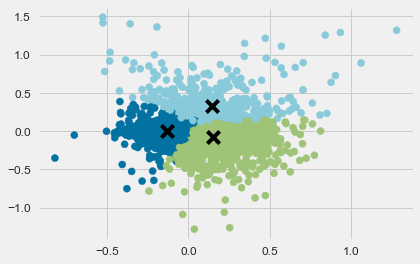

In [189]:
# Imput true k based on previous methods and run final model
true_k = 3
d2v_enq = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
d2v_enq.fit(d2v_model_enq.dv.vectors)
d2v_enq_labels=d2v_enq.labels_
d2v_enq_cl=pd.DataFrame(list(zip(enquiry_text["final_text"],d2v_enq_labels)),columns=['title','cluster'])
print(d2v_enq_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(d2v_model_enq.dv.vectors)
datapoint = pca.transform(d2v_model_enq.dv.vectors)
plt.figure
label1 = ["b", "g", "c", "r"]
color = [label1[i] for i in d2v_enq_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = d2v_enq.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()


In [190]:
# Evaluation metrics
# silhouette
print(silhouette_score(d2v_model_enq.dv.vectors, d2v_enq_labels))

# db and ch score
db_index = davies_bouldin_score(d2v_model_enq.dv.vectors, d2v_enq_labels)
ch_index = calinski_harabasz_score(d2v_model_enq.dv.vectors, d2v_enq_labels)
print(db_index)
print(ch_index)

0.14706121
2.6949963379027544
518.4638168750836


### Combined

In [177]:
# Generate vectors for model training
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_comb = []
j=0
for em in comb_text["final_text"].values:
    all_content_comb.append(LabeledSentence1(em,[j]))
    j+=1
print("Number of texts processed: ", j)

Number of texts processed:  13226


In [178]:
# Define parameters for Doc2vec model
d2v_model_comb = Doc2Vec(all_content_comb, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)

# Train model
d2v_model_comb.train(all_content_comb, total_examples=d2v_model_comb.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

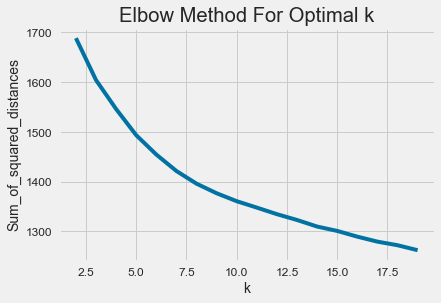

In [179]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(d2v_model_comb.dv.vectors)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

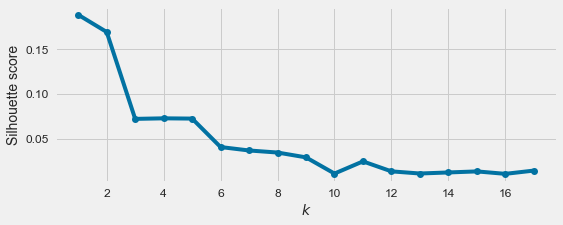

In [180]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(d2v_model_comb.dv.vectors)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(d2v_model_comb.dv.vectors, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=2)

                                                   title  cluster
0      staying relative europe year family breakdown ...        0
4315   partner rough sleeping since friend sofa surfi...        0
9482   call professional college wanting advice optio...        0
9483   message received please help given temporary s...        0
9487   tell contacted homeless kicked said need somew...        0
...                                                  ...      ...
4436         mother attempting evicted stephan sexuality        1
4438   stella newham college called student female ca...        1
4439   staying hotel money sarah explained previously...        1
4411   illegally evicted landlord arrived police offi...        1
13225  email received completed referral form hello a...        1

[13226 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

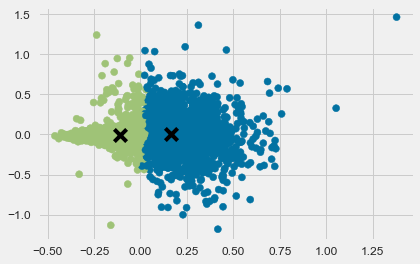

In [184]:
# Imput true k based on previous methods and run final model
true_k = 2
d2v_comb = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
d2v_comb.fit(d2v_model_comb.dv.vectors)
d2v_comb_labels=d2v_comb.labels_
d2v_comb_cl=pd.DataFrame(list(zip(comb_text["final_text"],d2v_comb_labels)),columns=['title','cluster'])
print(d2v_comb_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(d2v_model_comb.dv.vectors)
datapoint = pca.transform(d2v_model_comb.dv.vectors)
plt.figure
label1 = ["b", "g", "c", "r"]
color = [label1[i] for i in d2v_comb_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = d2v_comb.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()


In [185]:
# Evaluation metrics
# silhouette
print(silhouette_score(d2v_model_comb.dv.vectors, d2v_comb_labels))

# db and ch score
db_index = davies_bouldin_score(d2v_model_comb.dv.vectors, d2v_comb_labels)
ch_index = calinski_harabasz_score(d2v_model_comb.dv.vectors, d2v_comb_labels)
print(db_index)
print(ch_index)

0.22719058
2.2527730518820963
1885.1285836204038


### distill roberta <a class="anchor" id="threeciii"></a>

In [197]:
# Code Source: https://github.com/UKPLab/sentence-transformers
# Model Information Source: https://www.sbert.net/docs/pretrained_models.html

# Define distil roberta model
dist_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [206]:
# Create sentence values for each data set

#hepline
help_sentences = helpline_text["final_text"].values

#enquiry
enq_sentences = enquiry_text["final_text"].values

#combined
comb_sentences = comb_text['final_text'].values

In [209]:
# Generate encoded sentence embeddings for each data set

#hepline
help_sentence_embeddings = dist_model.encode(help_sentences)

#enquiry
enq_sentence_embeddings = dist_model.encode(enq_sentences)

#combined
comb_sentences_embeddings = dist_model.encode(comb_sentences)

### Helpline

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

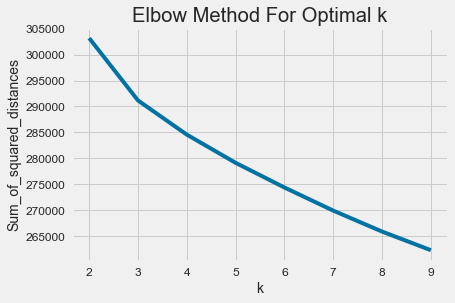

In [210]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(help_sentence_embeddings)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

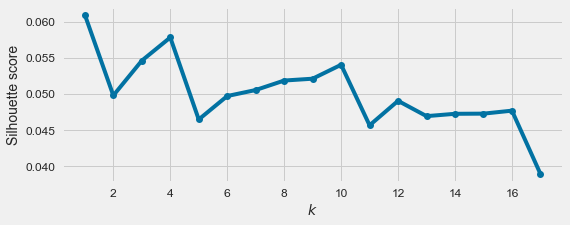

In [211]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(help_sentence_embeddings)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(help_sentence_embeddings, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=3)

                                                  title  cluster
6671  trying area long time seems like southward tak...        0
2322  partner rough sleeping partner currently recei...        0
2323                       currently staying tent month        0
5469                                                           0
2325  currently living conservatory uncle house gett...        0
...                                                 ...      ...
2995  currently life parent state lot argument confl...        2
2994               disclose living stated made homeless        2
2992  client restraining order cannot return propert...        2
2999  living parent state constantly arguing asked l...        2
3335            living hotel airport family asked leave        2

[6672 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

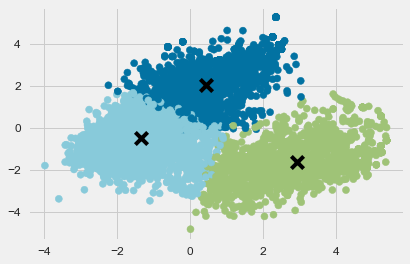

In [212]:
# Input true k based on previous methods and run final model
true_k = 3
dist_help_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
dist_help_model.fit(help_sentence_embeddings)
dist_help_labels=dist_help_model.labels_
dist_help_cl=pd.DataFrame(list(zip(helpline_text["final_text"],dist_help_labels)),columns=['title','cluster'])
print(dist_help_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(help_sentence_embeddings)
datapoint = pca.transform(help_sentence_embeddings)
plt.figure
label1 = ["b", "g", "c", "r"]
color = [label1[i] for i in dist_help_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = dist_help_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [218]:
# Evaluation metrics
# silhouette
print(silhouette_score(help_sentence_embeddings, dist_help_labels))

# db and ch score
db_index = davies_bouldin_score(help_sentence_embeddings, dist_help_labels)
ch_index = calinski_harabasz_score(help_sentence_embeddings, dist_help_labels)
print(db_index)
print(ch_index)

0.060994174
3.8014058042672567
354.11087449862197


### Enquiry

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

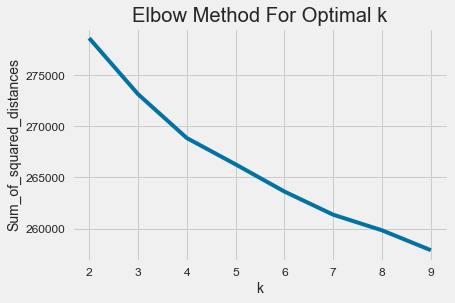

In [213]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(enq_sentence_embeddings)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

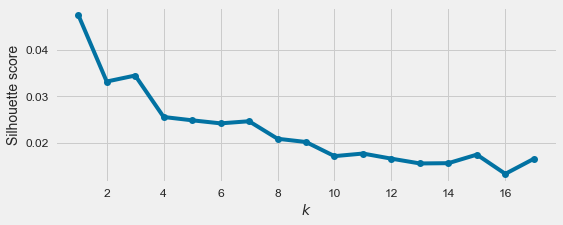

In [214]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(enq_sentence_embeddings)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(enq_sentence_embeddings, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=3)

                                                  title  cluster
0     working recently returned country fleeing gang...        0
2020  homeless today need emergency help staying che...        0
2021      month daughter made homeless need help advice        0
2024  sigma contacted homeless sofa surfing sleeping...        0
2027  bradley came parent kicked staying barking dag...        0
...                                                 ...      ...
707   received call grandparent grandson facing evic...        2
4427  called kelly client calling client served sect...        2
2467  enquiry received message currently homeless di...        2
2464  call lauren received stated partner homeless l...        2
4852  hello alexandra called regard year daughter ev...        2

[6554 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

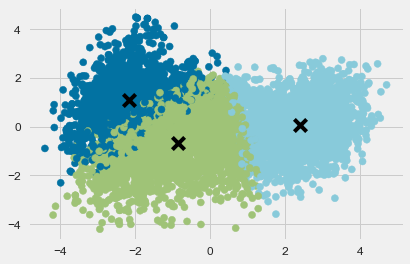

In [216]:
# Input true k based on previous methods and run final model
true_k = 3
dist_enq_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
dist_enq_model.fit(enq_sentence_embeddings)
dist_enq_labels=dist_enq_model.labels_
dist_enq_cl=pd.DataFrame(list(zip(enquiry_text["final_text"],dist_enq_labels)),columns=['title','cluster'])
print(dist_enq_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(enq_sentence_embeddings)
datapoint = pca.transform(enq_sentence_embeddings)
plt.figure
label1 = ["b", "g", "c", "r"]
color = [label1[i] for i in dist_enq_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = dist_enq_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [217]:
# Evaluation metrics
# silhouette
from sklearn.metrics import silhouette_score
print(silhouette_score(enq_sentence_embeddings, dist_enq_labels))

# db and ch score
db_index = davies_bouldin_score(enq_sentence_embeddings, dist_enq_labels)
ch_index = calinski_harabasz_score(enq_sentence_embeddings, dist_enq_labels)
print(db_index)
print(ch_index)

0.047730356
4.841536255437223
327.23985946764196


### Combined

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

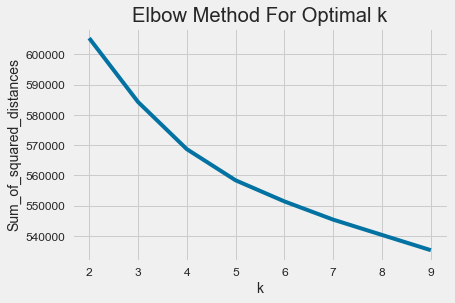

In [219]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(comb_sentences_embeddings)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

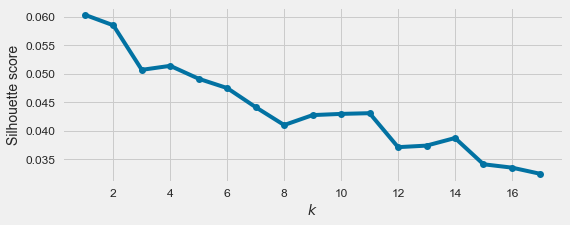

In [220]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(comb_sentences_embeddings)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(comb_sentences_embeddings, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=4)

                                                   title  cluster
0      staying relative europe year family breakdown ...        0
10119  enquiry involved police live family dont want ...        0
10122  call male turning next month discussed likelih...        0
5077         currently foster family told need leave day        0
5076   currently life family argument breakdown relat...        0
...                                                  ...      ...
3282   staying around different address last year cur...        3
3281                  living student accommodation month        3
3280                                        homeless day        3
3214                       rough sleeping partner kicked        3
6612                                             abusive        3

[13226 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

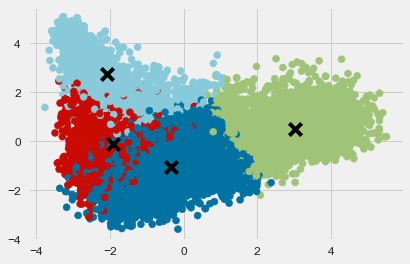

In [222]:
# Input true k based on previous methods and run final model
true_k = 4
dist_comb_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
dist_comb_model.fit(comb_sentences_embeddings)
dist_comb_labels=dist_comb_model.labels_
dist_comb_cl=pd.DataFrame(list(zip(comb_text["final_text"],dist_comb_labels)),columns=['title','cluster'])
print(dist_comb_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(comb_sentences_embeddings)
datapoint = pca.transform(comb_sentences_embeddings)
plt.figure
label1 = ["b", "g", "c", "r"]
color = [label1[i] for i in dist_comb_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = dist_comb_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [224]:
# Evaluation metrics
# silhouette
print(silhouette_score(comb_sentences_embeddings, dist_comb_labels))

# db and ch score
db_index = davies_bouldin_score(comb_sentences_embeddings, dist_comb_labels)
ch_index = calinski_harabasz_score(comb_sentences_embeddings, dist_comb_labels)
print(db_index)
print(ch_index)

0.05850739
3.867152908398438
634.4742354898665


### mp net <a class="anchor" id="threeciv"></a>

In [225]:
# Code Source: https://github.com/UKPLab/sentence-transformers
# Model Information Source: https://www.sbert.net/docs/pretrained_models.html

# Define mp net model
mp_net_model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [226]:
# Generate encoded sentence embeddings for each data set

#helpline
mp_help_sentence_embeddings = mp_net_model.encode(help_sentences)

#enquiry
mp_enq_sentence_embeddings = mp_net_model.encode(enq_sentences)

#combined
mp_comb_sentence_embeddings = mp_net_model.encode(comb_sentences)

### Helpline

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

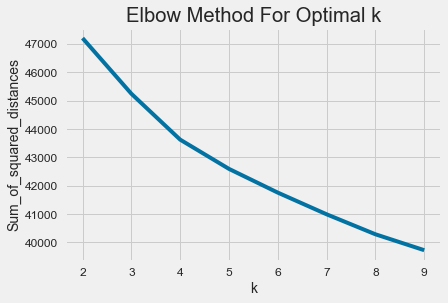

In [227]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(mp_help_sentence_embeddings)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

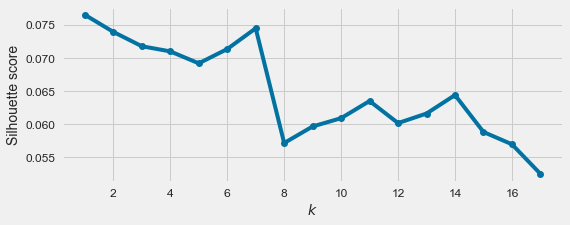

In [228]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(mp_help_sentence_embeddings)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(mp_help_sentence_embeddings, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=4)

                                                  title  cluster
0     staying relative europe year family breakdown ...        0
3483  hospital concern around mental health discharg...        0
3487                     living friend cannot stay past        0
3489  previously living shared house said closed cov...        0
3490                                     staying friend        0
...                                                 ...      ...
5143  currently rough sleeping following family brea...        3
566   partner currently sleeping rough park disclose...        3
6003                   rough sleeping since friday week        3
1020                           rough sleeping past week        3
356                                       nightmare day        3

[6672 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

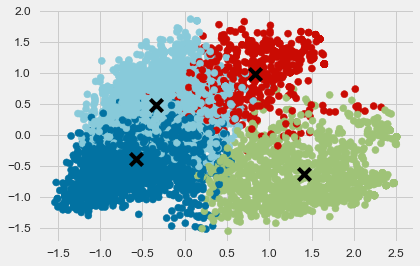

In [235]:
# Imput true k based on previous methods and run final model
true_k = 4
mp_help_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
mp_help_model.fit(mp_help_sentence_embeddings)
mp_help_labels=mp_help_model.labels_
mp_help_cl=pd.DataFrame(list(zip(helpline_text["final_text"],mp_help_labels)),columns=['title','cluster'])
print(mp_help_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(mp_help_sentence_embeddings)
datapoint = pca.transform(mp_help_sentence_embeddings)
plt.figure
label1 = ["b", "g", "c", "r","y"]
color = [label1[i] for i in mp_help_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = mp_help_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [236]:
# Evaluation metrics
# silhouette
print(silhouette_score(mp_help_sentence_embeddings, mp_help_labels))

# db and ch score
db_index = davies_bouldin_score(mp_help_sentence_embeddings, mp_help_labels)
ch_index = calinski_harabasz_score(mp_help_sentence_embeddings, mp_help_labels)
print(db_index)
print(ch_index)

0.07397869
3.449314160873812
384.1890830562023


### Enquiry

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

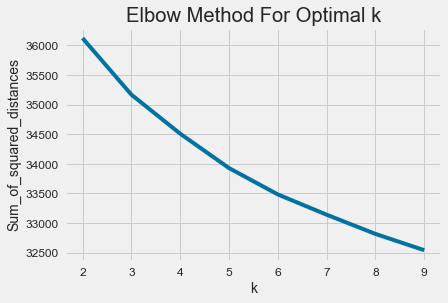

In [229]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(mp_enq_sentence_embeddings)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

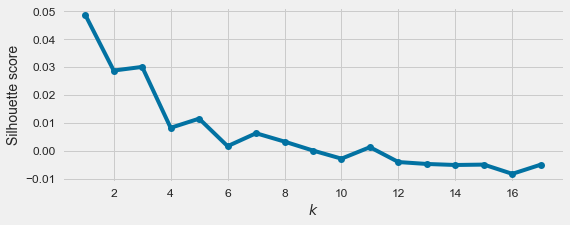

In [230]:
# Find optimal k using silhoeutte method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(mp_enq_sentence_embeddings)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(mp_enq_sentence_embeddings, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=3)

                                                  title  cluster
6553  email received completed referral form hello a...        0
2136  concerned young seen sleeping rough solo wante...        0
2137  pedro contacted isnt getting want look younger...        0
2138  left home night without food cook go come back...        0
5110  duty refer received hello please attached duty...        0
...                                                 ...      ...
2180          sofa surfing mum overcrowded moving devon        2
2181  wanted advice friend homeless problem also hea...        2
2182  staying friend month kicked mother house curre...        2
2158  raion contacted homeless released prison rough...        2
3276    homeless need home wondering whether could help        2

[6554 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

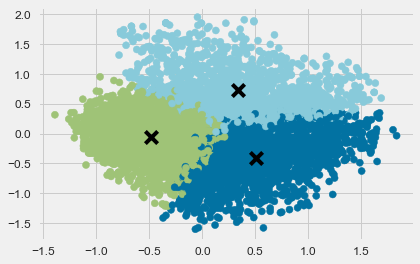

In [237]:
# Imput true k based on previous methods and run final model
true_k = 3
mp_enq_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
mp_enq_model.fit(mp_enq_sentence_embeddings)
mp_enq_labels=mp_enq_model.labels_
mp_enq_cl=pd.DataFrame(list(zip(enquiry_text["final_text"],mp_enq_labels)),columns=['title','cluster'])
print(mp_enq_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(mp_enq_sentence_embeddings)
datapoint = pca.transform(mp_enq_sentence_embeddings)
plt.figure
label1 = ["b", "g", "c", "r","y"]
color = [label1[i] for i in mp_enq_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = mp_enq_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [238]:
# Evaluation metrics
# silhouette
print(silhouette_score(mp_enq_sentence_embeddings, mp_enq_labels))

# db and ch score
db_index = davies_bouldin_score(mp_enq_sentence_embeddings, mp_enq_labels)
ch_index = calinski_harabasz_score(mp_enq_sentence_embeddings, mp_enq_labels)
print(db_index)
print(ch_index)

0.05072568
4.307526272974893
242.24421400985082


### Combined

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

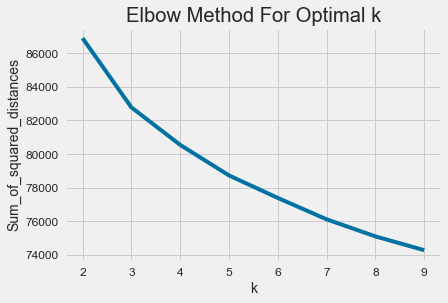

In [231]:
# Find optimal k using elbow method
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=42)
   km = km.fit(mp_comb_sentence_embeddings)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 576x216 with 0 Axes>

Text(0.5, 0, '$k$')

Text(0, 0.5, 'Silhouette score')

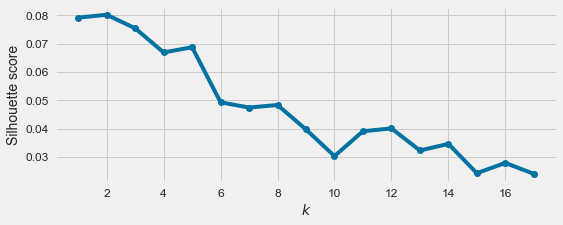

In [232]:
# Find optimal k using silhouette method
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(mp_comb_sentence_embeddings)
                for k in range(2, 20)]

silhouette_scores = [silhouette_score(mp_comb_sentence_embeddings, km.labels_)
                     for km in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 18), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

KMeans(max_iter=200, n_clusters=3)

                                                  title  cluster
3468  evicted hostel sofa surfing since support work...        0
2231  rough sleeping past night stayed last night st...        0
2232                             rough sleeping tonight        0
5334                                           sleeping        0
5332                        sofa surfing currently week        0
...                                                 ...      ...
4707                                  given notice june        2
4708  currently hostel self contained unit arranged ...        2
4711                          currently life leave week        2
4702                 disclose current housing situation        2
6612                                            abusive        2

[13226 rows x 2 columns]


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

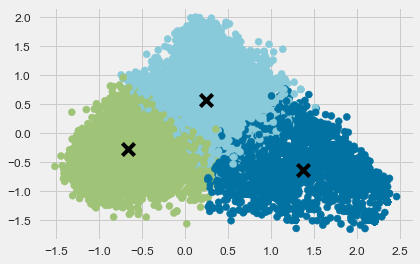

In [239]:
# Input true k based on previous methods and run final model
true_k = 3
mp_comb_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
mp_comb_model.fit(mp_comb_sentence_embeddings)
mp_comb_labels=mp_comb_model.labels_
mp_comb_cl=pd.DataFrame(list(zip(comb_text["final_text"],mp_comb_labels)),columns=['title','cluster'])
print(mp_comb_cl.sort_values(by=['cluster']))

# Use PCA to visualize the clusters from the final model
pca = PCA(n_components=2).fit(mp_comb_sentence_embeddings)
datapoint = pca.transform(mp_comb_sentence_embeddings)
plt.figure
label1 = ["b", "g", "c", "r","y"]
color = [label1[i] for i in mp_comb_labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = mp_comb_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='black')
plt.show()

In [240]:
# Evaluation metrics
# silhouette
print(silhouette_score(mp_comb_sentence_embeddings, mp_comb_labels))

# db and ch score
db_index = davies_bouldin_score(mp_comb_sentence_embeddings, mp_comb_labels)
ch_index = calinski_harabasz_score(mp_comb_sentence_embeddings, mp_comb_labels)
print(db_index)
print(ch_index)

0.078809716
3.553981348837049
826.3282463295827


## Free Text Data Visualization <a class="anchor" id="threed"></a>

This section uses word clouds, bi-gram and tri-gram analysis, and word and sentence length charts to provide a descriptive overview of the free text features of each data set. As the figures show, both data sets consist of shorter entries (generally under 100 words) and are fairly homogenous, with the top four or five bi and tri gram combinations making up a large share of the total vocabulary.

In [242]:
# Create set of all tokens from each data set
help_tokens = helpline_text['clean_tokens']
enq_tokens = enquiry_text['clean_tokens']
comb_tokens = comb_text['clean_tokens']

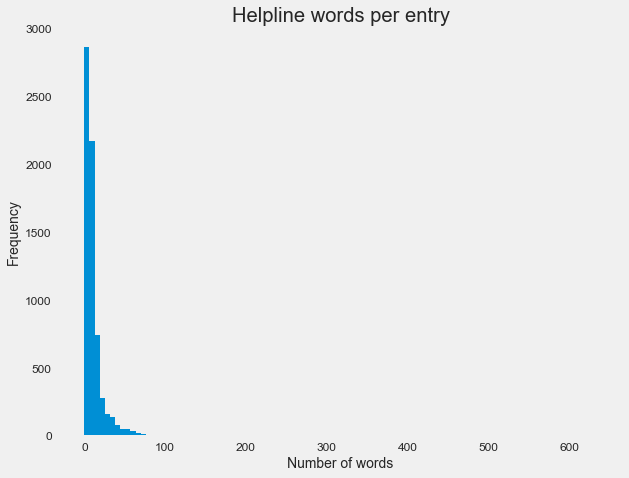

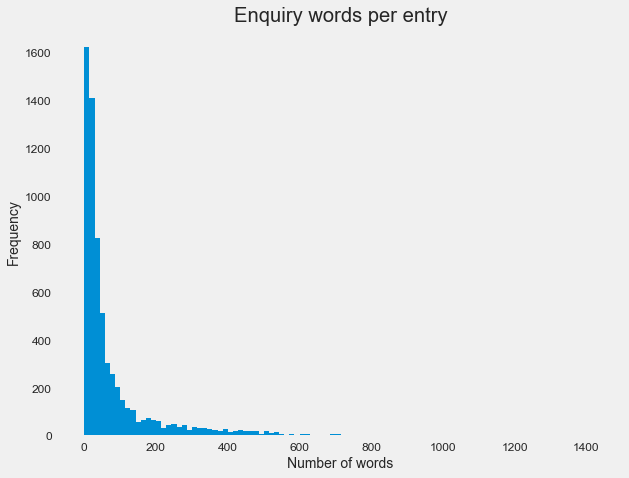

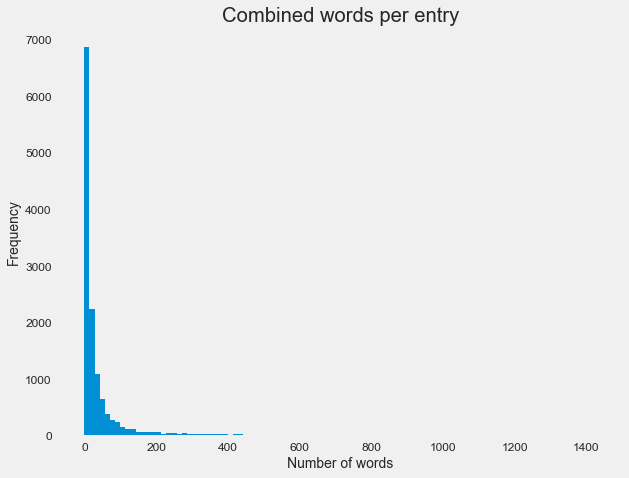

In [245]:
# Number of words in each entry in helpline data
ax = help_tokens.str.len().hist(grid=False, figsize=(9,7), bins=100)
ax = plt.xlabel('Number of words')
ax = plt.ylabel('Frequency')
ax = plt.title('Helpline words per entry')
plt.show()

# Number of words in each entry in enquiry data
ax = enq_tokens.str.len().hist(grid=False, figsize=(9,7), bins=100)
ax = plt.xlabel('Number of words')
ax = plt.ylabel('Frequency')
ax = plt.title('Enquiry words per entry')
plt.show()

# Number of words in each entry in combined data
ax = comb_tokens.str.len().hist(grid=False, figsize=(9,7), bins=100)
ax = plt.xlabel('Number of words')
ax = plt.ylabel('Frequency')
ax = plt.title('Combined words per entry')
plt.show()

C:\Users\geaco\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.


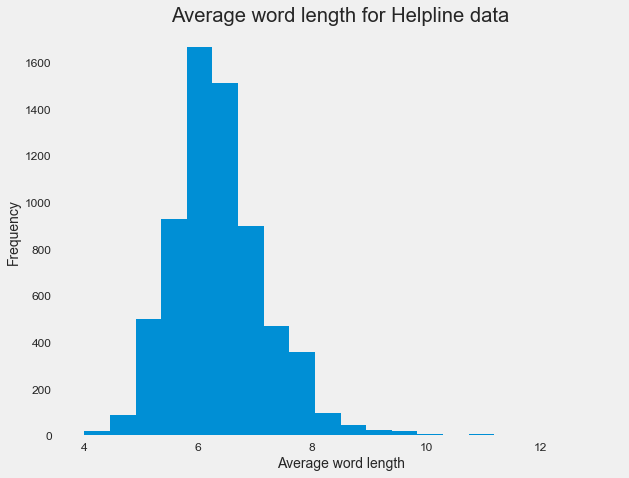

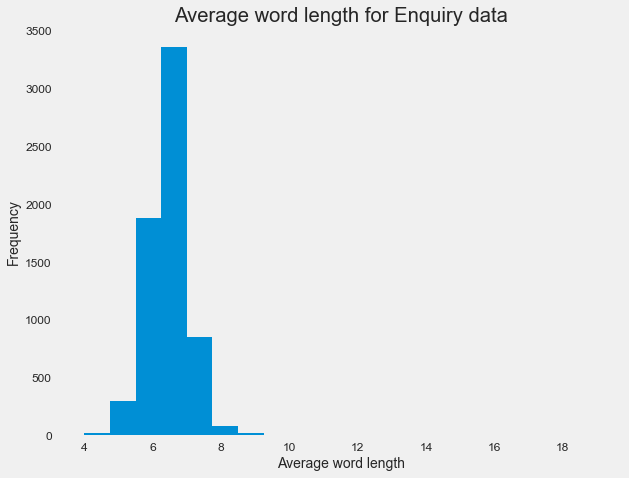

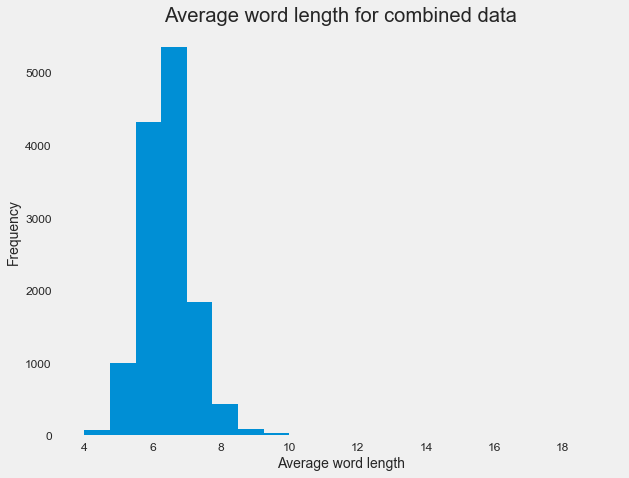

In [247]:
# check the average word length in each helpline entry
_ = help_tokens.apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)).hist(grid=False, bins=20, figsize=(9,7))
_ = plt.xlabel('Average word length')
_ = plt.ylabel('Frequency')
_ = plt.title('Average word length for Helpline data')
plt.show()

# check the average word length in each enquiry entry
_ = enq_tokens.apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)).hist(grid=False, bins=20, figsize=(9,7))
_ = plt.xlabel('Average word length')
_ = plt.ylabel('Frequency')
_ = plt.title('Average word length for Enquiry data')
plt.show()

# check the average word length in each combined entry
_ = comb_tokens.apply(lambda x: [len(word) for word in x]).apply(lambda y: np.mean(y)).hist(grid=False, bins=20, figsize=(9,7))
_ = plt.xlabel('Average word length')
_ = plt.ylabel('Frequency')
_ = plt.title('Average word length for combined data')
plt.show()

<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

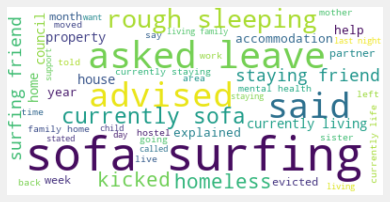

<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

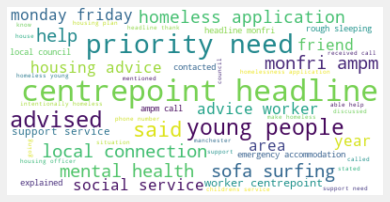

<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

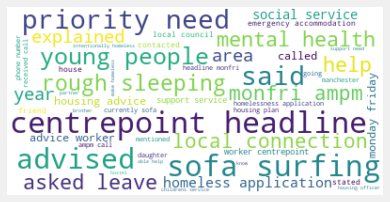

In [283]:
# World clouds for each data set- top 50 words
# helpline
wordcloud_help = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(helpline_text['final_text']))
plt.figure()
plt.imshow(wordcloud_help, interpolation="bilinear")
plt.axis("off")
plt.show()

# enquiry
wordcloud_enq = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(enquiry_text['final_text']))
plt.figure()
plt.imshow(wordcloud_enq, interpolation="bilinear")
plt.axis("off")
plt.show()

#combined
wordcloud_comb = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(comb_text['final_text']))
plt.figure()
plt.imshow(wordcloud_comb, interpolation="bilinear")
plt.axis("off")
plt.show()

In [248]:
# Generate data for bi-gram and tri-gram analysis
# helpline
bigrams_one = help_tokens.apply(lambda x: ngrams(x,2))
bi_grams_one = bigrams_one.apply(lambda x: list(x))
top_20_bigrams_one = Counter(itertools.chain.from_iterable(bi_grams_one)).most_common(20)

trigrams_one = help_tokens.apply(lambda x: ngrams(x,3))
tri_grams_one = trigrams_one.apply(lambda x: list(x))
top_20_trigrams_one = Counter(itertools.chain.from_iterable(tri_grams_one)).most_common(20)

#enquiry
bigrams_two = enq_tokens.apply(lambda x: ngrams(x,2))
bi_grams_two = bigrams_two.apply(lambda x: list(x))
top_20_bigrams_two = Counter(itertools.chain.from_iterable(bi_grams_two)).most_common(20)

trigrams_two = enq_tokens.apply(lambda x: ngrams(x,3))
tri_grams_two = trigrams_two.apply(lambda x: list(x))
top_20_trigrams_two = Counter(itertools.chain.from_iterable(tri_grams_two)).most_common(20)

#combined
bigrams_three = comb_tokens.apply(lambda x: ngrams(x,2))
bi_grams_three = bigrams_three.apply(lambda x: list(x))
top_20_bigrams_three = Counter(itertools.chain.from_iterable(bi_grams_three)).most_common(20)

trigrams_three = comb_tokens.apply(lambda x: ngrams(x,3))
tri_grams_three = trigrams_three.apply(lambda x: list(x))
top_20_trigrams_three = Counter(itertools.chain.from_iterable(tri_grams_three)).most_common(20)

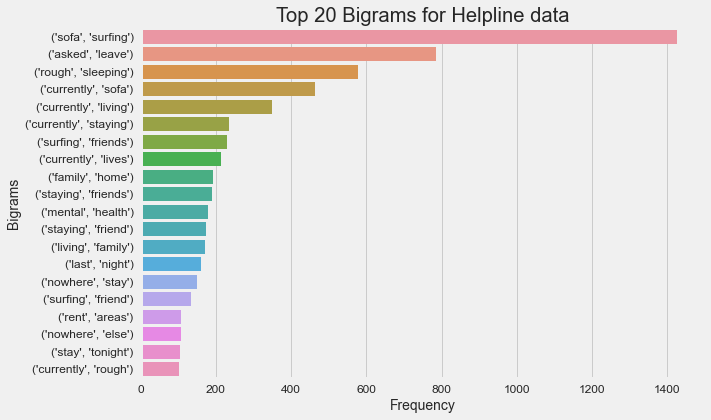

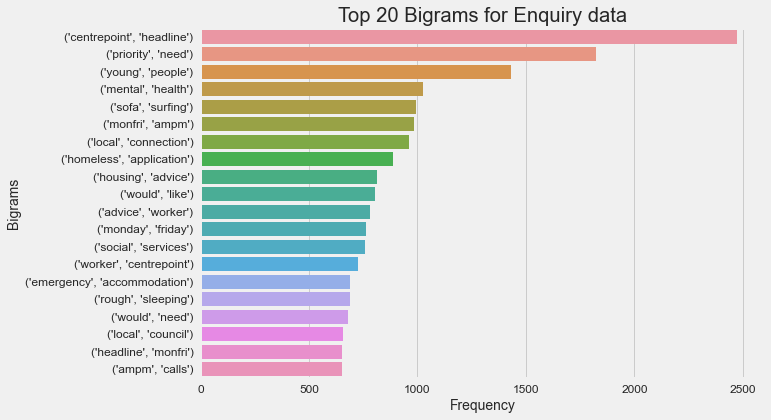

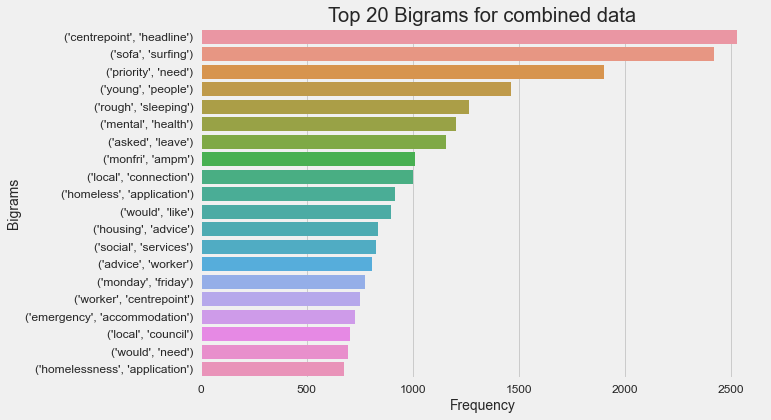

In [250]:
# Create bi-gram charts 
# helpline
top_bigram_one = pd.DataFrame(top_20_bigrams_one, columns=['bigram', 'frequency'])
top_bigram_one.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(9,6))
_ = sns.barplot(x=top_bigram_one.frequency, y=top_bigram_one.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams for Helpline data')
plt.show()

# enquiry
top_bigram_two = pd.DataFrame(top_20_bigrams_two, columns=['bigram', 'frequency'])
top_bigram_two.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(9,6))
_ = sns.barplot(x=top_bigram_two.frequency, y=top_bigram_two.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams for Enquiry data')
plt.show()

# combined
top_bigram_three = pd.DataFrame(top_20_bigrams_three, columns=['bigram', 'frequency'])
top_bigram_three.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(9,6))
_ = sns.barplot(x=top_bigram_three.frequency, y=top_bigram_three.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Bigrams')
_ = plt.title('Top 20 Bigrams for combined data')
plt.show()


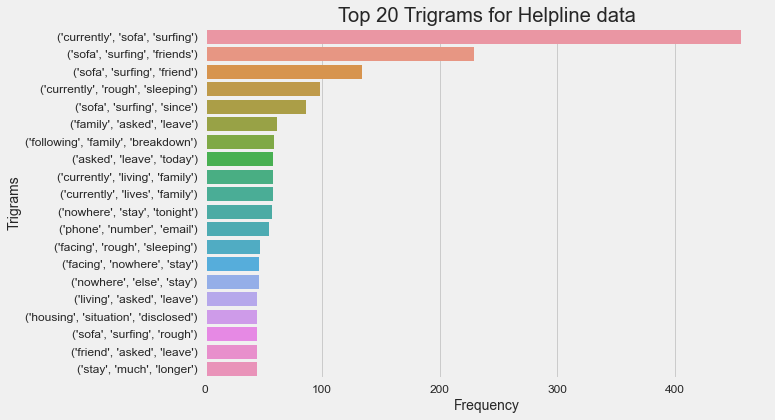

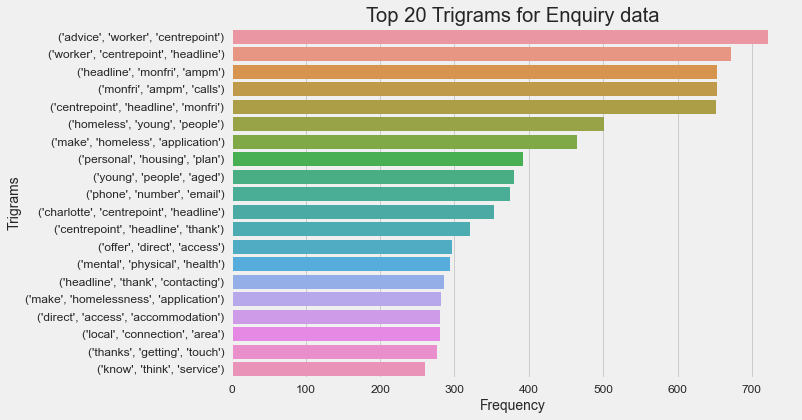

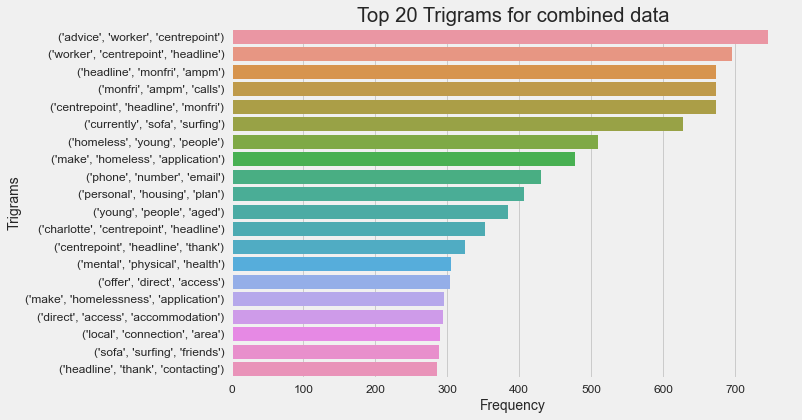

In [249]:
# Create tri-gram charts 
# helpline
top_trigram_one = pd.DataFrame(top_20_trigrams_one, columns=['bigram', 'frequency'])
top_trigram_one.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(9,6))
_ = sns.barplot(x=top_trigram_one.frequency, y=top_trigram_one.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Trigrams')
_ = plt.title('Top 20 Trigrams for Helpline data')
plt.show()

# enquiry
top_trigram_two = pd.DataFrame(top_20_trigrams_two, columns=['bigram', 'frequency'])
top_trigram_two.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(9,6))
_ = sns.barplot(x=top_trigram_two.frequency, y=top_trigram_two.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Trigrams')
_ = plt.title('Top 20 Trigrams for Enquiry data')
plt.show()

# combined
top_trigram_three = pd.DataFrame(top_20_trigrams_three, columns=['bigram', 'frequency'])
top_trigram_three.set_index('bigram', inplace=True)
_ = plt.figure(figsize=(9,6))
_ = sns.barplot(x=top_trigram_three.frequency, y=top_trigram_three.index, orient='h')
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Trigrams')
_ = plt.title('Top 20 Trigrams for combined data')
plt.show()

## Free Text Model Cluster Analysis For Best Performing Model <a class="anchor" id="threee"></a>

Based on the evaluation criteria chosen in the previous section, all the models performed much better on just the helpline data than on the enquiry or combined datasets, and TF-IDF model was the best performer on the helpline dataset. The optimal k for the TF-IDF model on the helpline dataset produced ten clusters. This section analyzes those clusters by visualizing their size via a silhouette score plot, generating word clouds for each cluster, and by providing a descriptive overview of the categorical features associated with the record id's of each cluster.

Overall, even the best performing model did not produce very well-defined clusters, with a silhouette score of only .37. This is reiterated in the visualizations, where it is apparent that much of the variation between clusters comes from the housing situation described in the call (phrases such as sofa surfing, rough sleeping, living with family or friends, and kicked out), but do not provide much more detailed insights beyond that. Due to the limitations stemming from the data collection process and data quality issues, this was not the ideal dataset for forming the most distinct clusters, however, I believe the methodology is useful for repeating similar analysis on datasets consisting of both unstructured and structed feature types.

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=2,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=3,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=4,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=5,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=6,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=7,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=9,
                                      random_state=42))

'\n    Create KMeans instance for different number of clusters\n    '

'\n    Create SilhouetteVisualizer instance with KMeans instance\n    Fit the visualizer\n    '

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=10,
                                      random_state=42))

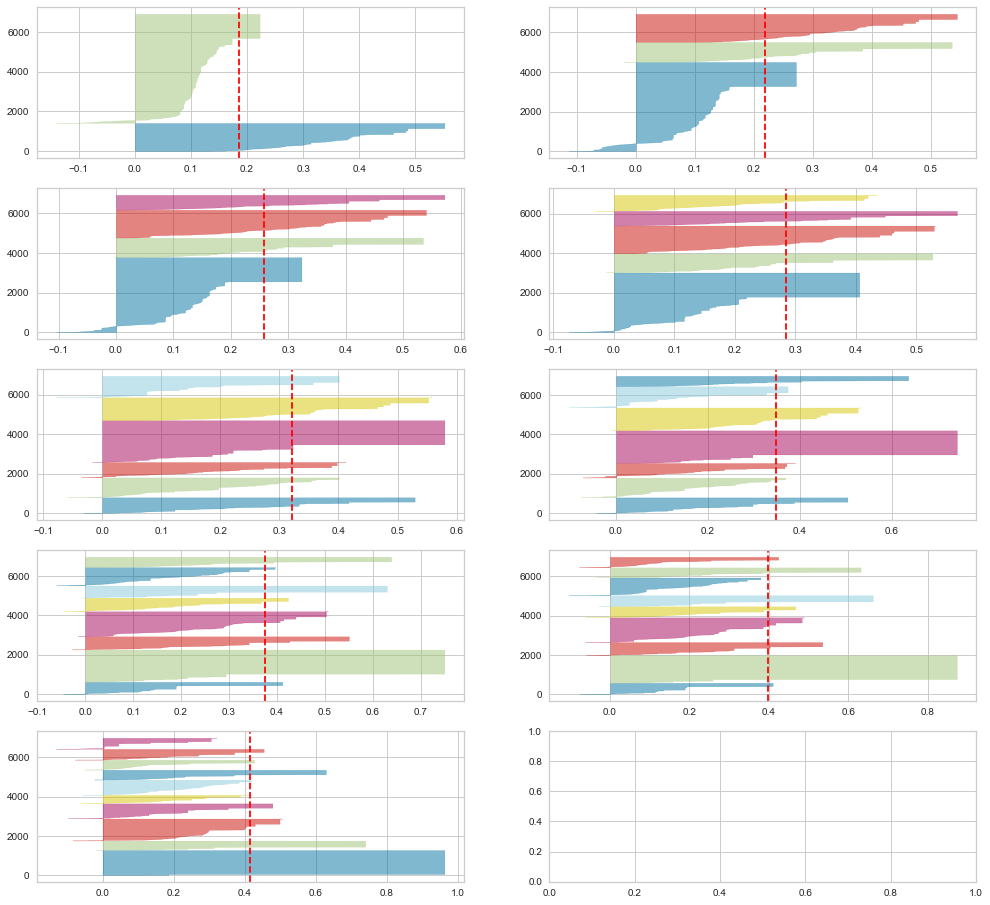

In [11]:
# Visualize silhouette scores for best performing model
fig, ax = plt.subplots(5, 2, figsize=(15,15))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_help)  

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=200, n_clusters=10,
                                      random_state=42))

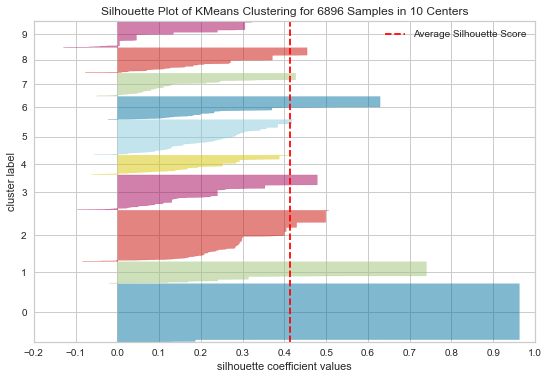

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 6896 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
# Show chart ofr only optimal number of clusters for paper presentation
km = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=200, random_state=42)

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
                                     
visualizer.fit(X_help) 
visualizer.show()

Cluster: 0


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

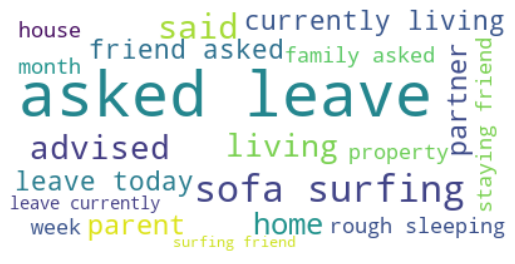

Cluster: 1


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

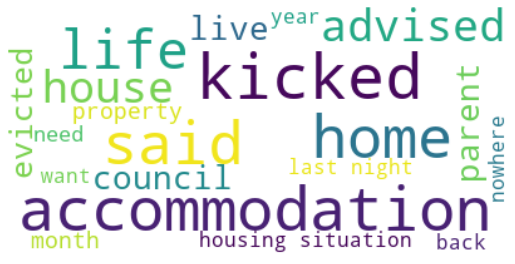

Cluster: 2


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

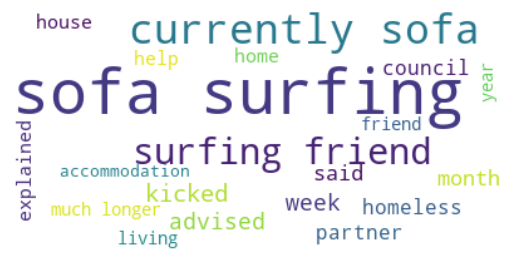

Cluster: 3


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

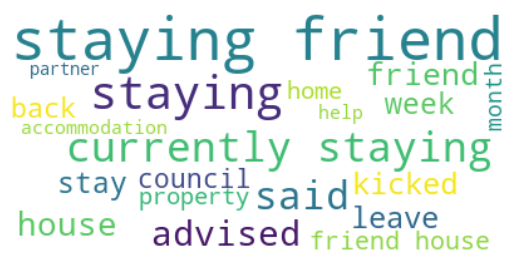

Cluster: 4


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

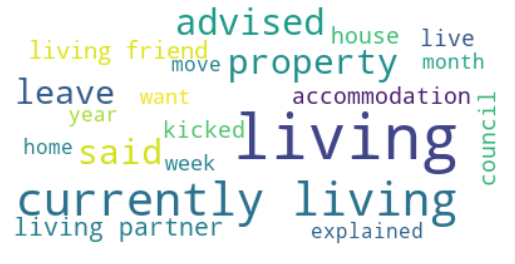

Cluster: 5


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

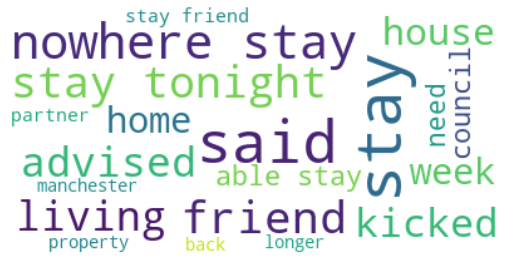

Cluster: 6


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

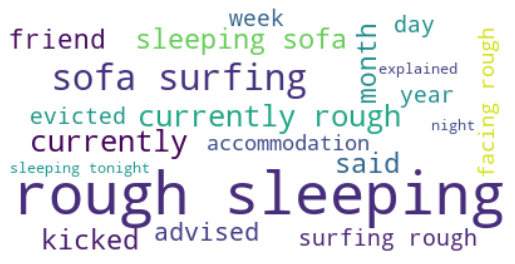

Cluster: 7


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

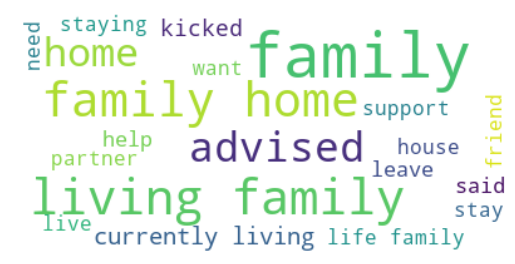

Cluster: 8


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

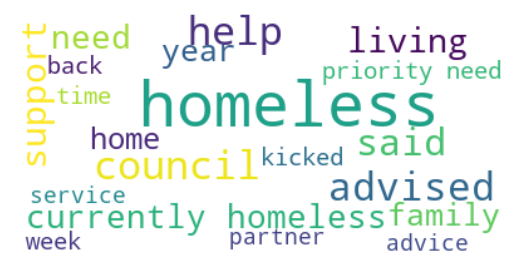

Cluster: 9


<Figure size 576x396 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

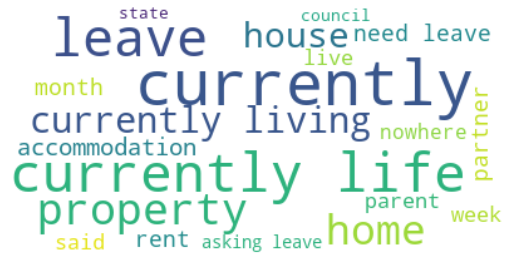

In [43]:
# Generate word clouds of the top 20 words from each cluster
cloud = td_help_cl['title']
result={'cluster':td_help_labels,'wiki':cloud}
result=pd.DataFrame(result)
result['wiki'] = result['wiki'].astype('string')
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [12]:
# Cluster Interpretation

# Add the cluster to the dataframe
helpline_text['Cluster Labels'] = td_help_labels
helpline_text['Segment'] = helpline_text['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third',3:'Fourth',4:'Fifth'
                                                                ,5:'Sixth',6:'Seventh',7:'Eighth',8:'Ninth',9:'Tenth'})
# Order the cluster
helpline_text['Segment'] = helpline_text['Segment'].astype('category')
helpline_text['Segment'] = helpline_text['Segment'].cat.reorder_categories(['First','Second','Third','Fourth','Fifth','Sixth',
                                                                            'Seventh','Eighth','Ninth','Tenth'])
# Show the first 5 rows
helpline_text.head()

index                                         spellcheck  \
0      1  young person has been staying with relatives i...   
1      2       He had no job and went to Malaysia to settle   
2     13  Was in a refuse but had to leave due to someon...   
3     17  young person is currently sleeping in their co...   
4     18  Living with ex - partner's mum, so still expos...   

                                                text  \
0   has been staying with relatives in europe for...   
1       he had no job and went to malaysia to settle   
2  was in a refuse but had to leave due to someon...   
3   is currently sleeping in their cousins car af...   
4  living with ex  partners mum so still exposed ...   

                                              tokens  \
0  [, has, been, staying, with, relatives, in, eu...   
1  [he, had, no, job, and, went, to, malaysia, to...   
2  [was, in, a, refuse, but, had, to, leave, due,...   
3  [, is, currently, sleeping, in, their, cousins...   
4  [living, with, ex, partners, mum, so, still, e...   

                                       larger_tokens  \
0  [been, staying, with, relatives, europe, years...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, their, cousins, after, b...   
4  [living, with, partners, still, exposed, behav...   

                                        clean_tokens  \
0  [staying, relatives, europe, years, family, br...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, cousins, evicted, stonep...   
4  [living, partners, still, exposed, behaviour, ...   

                                          stem_words  \
0  [stay, rel, europ, year, famili, breakdown, ta...   
1                            [went, malaysia, settl]   
2              [refus, leav, someon, turn, accommod]   
3  [current, sleep, cousin, evict, stonepillow, h...   
4  [live, partner, still, expos, behaviour, want,...   

                                         lemma_words  \
0  [staying, relative, europe, year, family, brea...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, cousin, evicted, stonepi...   
4  [living, partner, still, exposed, behaviour, w...   

                                          final_text  Cluster Labels  Segment  
0  staying relative europe year family breakdown ...               7   Eighth  
1                               went malaysia settle               1   Second  
2         refuse leave someone turning accommodation               9    Tenth  
3  currently sleeping cousin evicted stonepillow ...               6  Seventh  
4   living partner still exposed behaviour want soon               4    Fifth

In [13]:
# Merge cluster with original helpline data set to view all features of each cluster
helpline = helpline.reset_index()
cluster_df = pd.merge(helpline, helpline_text, how="inner", on=["index"])
cluster_df.head()

index             Housing Situation Timeline Event Notes Timeline End Date  \
0      1            Living with family                  NaN               NaT   
1      2            Living with family                  NaN               NaT   
2     13  Did Not Disclose / Not Known                  NaN               NaT   
3     17                Rough sleeping                  NaN               NaT   
4     18            Living with family                  NaN               NaT   

  Referral date Timeline Start Date Approached Social Services  \
0    2020-08-14          2020-08-14                        NaN   
1    2020-09-07          2020-09-07                        NaN   
2    2020-07-22          2020-07-22                        NaN   
3    2020-02-13          2020-02-13                        NaN   
4    2020-02-26          2020-02-26                        NaN   

  Approached Housing                      In EET  \
0                NaN  Unknown / Did Not Disclose   
1                NaN  Unknown / Did Not Disclose   
2                NaN  Unknown / Did Not Disclose   
3                NaN                  Job Seeker   
4                NaN  Unknown / Did Not Disclose   

  Recurring Case of Homelessness  ...  \
0                     Don't Know  ...   
1                     Don't Know  ...   
2                     Don't Know  ...   
3                            NaN  ...   
4                             No  ...   

                                          spellcheck  \
0  young person has been staying with relatives i...   
1       He had no job and went to Malaysia to settle   
2  Was in a refuse but had to leave due to someon...   
3  young person is currently sleeping in their co...   
4  Living with ex - partner's mum, so still expos...   

                                                text  \
0   has been staying with relatives in europe for...   
1       he had no job and went to malaysia to settle   
2  was in a refuse but had to leave due to someon...   
3   is currently sleeping in their cousins car af...   
4  living with ex  partners mum so still exposed ...   

                                              tokens  \
0  [, has, been, staying, with, relatives, in, eu...   
1  [he, had, no, job, and, went, to, malaysia, to...   
2  [was, in, a, refuse, but, had, to, leave, due,...   
3  [, is, currently, sleeping, in, their, cousins...   
4  [living, with, ex, partners, mum, so, still, e...   

                                       larger_tokens  \
0  [been, staying, with, relatives, europe, years...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, their, cousins, after, b...   
4  [living, with, partners, still, exposed, behav...   

                                        clean_tokens  \
0  [staying, relatives, europe, years, family, br...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, cousins, evicted, stonep...   
4  [living, partners, still, exposed, behaviour, ...   

                                          stem_words  \
0  [stay, rel, europ, year, famili, breakdown, ta...   
1                            [went, malaysia, settl]   
2              [refus, leav, someon, turn, accommod]   
3  [current, sleep, cousin, evict, stonepillow, h...   
4  [live, partner, still, expos, behaviour, want,...   

                                         lemma_words  \
0  [staying, relative, europe, year, family, brea...   
1                           [went, malaysia, settle]   
2   [refuse, leave, someone, turning, accommodation]   
3  [currently, sleeping, cousin, evicted, stonepi...   
4  [living, partner, still, exposed, behaviour, w...   

                                          final_text Cluster Labels  Segment  
0  staying relative europe year family breakdown ...              7   Eighth  
1                               went malay

In [14]:
# Count of entries for each cluster
cluster_df['Segment'].value_counts()

Second     1220
Third      1113
Seventh     768
First       761
Fourth      607
Fifth       599
Ninth       506
Eighth      473
Tenth       461
Sixth       388
Name: Segment, dtype: int64

In [41]:
# Create data frame with modal and mean values of relevant features for each cluster
cluster_df.groupby('Segment').agg(
    {
        'Housing Situation': lambda x: x.value_counts().index[0],
        'Gender': lambda x: x.value_counts().index[0],
        'Region': lambda x: x.value_counts().index[0],
        'Main cause of homelessness': lambda x: x.value_counts().index[0],
        'At risk of Homelessness due to': lambda x: x.value_counts().index[0],
        'Age': 'mean'
    }
).reset_index()

Segment   Housing Situation  Gender              Region  \
0    First  Living with family  Female  North West England   
1   Second               Other  Female              London   
2    Third        Sofa-surfing  Female              London   
3   Fourth        Sofa-surfing  Female              London   
4    Fifth  Living with family  Female              London   
5    Sixth        Sofa-surfing  Female  North West England   
6  Seventh      Rough sleeping    Male              London   
7   Eighth  Living with family  Female  North West England   
8    Ninth               Other  Female              London   
9    Tenth  Living with family  Female  North West England   

  Main cause of homelessness At risk of Homelessness due to        Age  
0           Family breakdown               Family breakdown  22.069829  
1                  Not Known               Family breakdown  23.535685  
2           Family breakdown               Family breakdown  22.992812  
3           Family breakdown               Family breakdown  22.207578  
4                  Not Known               Family breakdown  22.205686  
5           Family breakdown               Family breakdown  22.368557  
6           Family breakdown               Family breakdown  23.510417  
7           Family breakdown               Family breakdown  21.875000  
8                  Not Known                        Unknown  23.905138  
9                  Not Known               Family breakdown  22.950108